# Calibrating the cloud clearing algorithm
The goal with the cloud clearing algorithm is to filter out areas where the cloud cover is too thick for any ice to be retrieved. This is a two-step process with multiple adjustable parameters: first all cloudy pixels are selected and added to the mask, then cloudy pixels that are likely to have visible ice are removed from the mask. Both steps use thresholds for intensity values from band 7 and band 2 of the MODIS false color imagery (7-2-1). The true color imagery can also be helpful, which includes bands 1-4-3.

Let the intensity value of band $i$ be given by $B_i$. The module then creates a binary mask with the following steps:
1. Mask all pixels with $B_7 > 110 = \tau_c$.
2. Unmask pixels with $B_7 < 200 = \tau_1$ and $B_2 > 190 = \tau_2$.
3. Unmask pixels with $B_7/B_2 < 0.75 = \tau_r$.

We evaluate the algorithm in two parts. First, we search for an optimum value for the cloud threshold $T_C$. Presently, the manual estimate of cloud fraction is our best estimate of the "truth" for the total cloud fraction $F$. The fraction of pixels with $B_7 > T_C$ is the estimated total cloud fraction $\hat{F}$. We select 2/3 of the data at random as the training dataset. To this subset, we apply $k$-fold cross validation, optimizing the choice of cloud threshold across $T_C = 0, 10, 20, \cdots, 200$. After computing RMSE for each choice of $T_C$, we find a best-fit quadratic interpolant and find the minimizing integer value of $T_C$. The optimal choice of $T_C$ is the average across the $k$ folds. We also report the mean $RMSE$ across the $k$ folds. Finally, we calculate the error in the cloud fraction relative to the remaining 1/3 of the data. 

This method performs fairly well against the manual (20% error) and the MODIS (10% error) datasets.

## Updated thoughts and planning for this part
1. It is obvious from examination of the images in "cf_mask" that a simple threshold on band 7 is not enough. It does do pretty well in some cases, but it is prone to error when there is land in the image, and when there is a mixture of ice and water pixels.
2. Based on my reading of the papers developing MODIS cloud and ice datasets, there are challenges with the cloud mask based on using a 25 km grid for sea ice cover in choosing how to apply the cloud algorithm. It uses different values for the ice and snow surfaces than for ocean and land surfaces. So direct comparison with the MODIS clouds will also have some errors.
3. As with other terms, joint measures are useful. 


In [2]:
import numpy as np
import os
import pandas as pd
import proplot as pplt
import rasterio as rio
from rasterio.plot import reshape_as_image
from sklearn.model_selection import KFold
from scipy.interpolate import interp1d

# Load the list of cloud clearing evaluation cases
dataloc = '../../eval_seg/'
df = pd.read_csv(dataloc + '/data/metadata/merged_validation_table.csv')
df['case_number'] = [str(cn).zfill(3) for cn in df['case_number']]
df.groupby('region').count()

/opt/homebrew/Caskroom/miniconda/base/envs/calval/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


case_number  start_date  center_lon  center_lat  \
region                                                                 
baffin_bay                    42          42          42          42   
barents_kara_seas             42          42          42          42   
beaufort_sea                  42          42          42          42   
bering_chukchi_seas           42          42          42          42   
east_siberian_sea             42          42          42          42   
greenland_sea                 42          42          42          42   
hudson_bay                    42          42          42          42   
laptev_sea                    42          42          42          42   
sea_of_okhostk                42          42          42          42   

                     center_x  center_y  month  sea_ice_fraction  \
region                                                             
baffin_bay                 42        42     42                42   
barents_kara_seas          42        42     42                42   
beaufort_sea               42        42     42                42   
bering_chukchi_seas        42        42     42                42   
east_siberian_sea          42        42     42                42   
greenland_sea              42        42     42                42   
hudson_bay                 42        42     42                42   
laptev_sea                 42        42     42                42   
sea_of_okhostk             42        42     42                42   

                     mean_sea_ice_concentration  init_case_number  ...  \
region                                                             ...   
baffin_bay                                   42                42  ...   
barents_kara_seas                            42                42  ...   
beaufort_sea                                 42                42  ...   
bering_chukchi_seas                          42                42  ...   
east_siberian_sea                            42                42  ...   
greenland_sea                                42                42  ...   
hudson_bay                                   42                42  ...   
laptev_sea                                   42                42  ...   
sea_of_okhostk                               42                42  ...   

                     visible_floes  cloud_fraction_manual  \
region                                                      
baffin_bay                      42                     42   
barents_kara_seas               42                     42   
beaufort_sea                    42                     42   
bering_chukchi_seas             42                     42   
east_siberian_sea               42                     42   
greenland_sea                   42                     42   
hudson_bay                      42                     42   
laptev_sea                      42                     42   
sea_of_okhostk                  42                     42   

                     cloud_category_manual  artifacts  qa_analyst  \
region                                                              
baffin_bay                              42         42          42   
barents_kara_seas                       42         42          42   
beaufort_sea                            42         42          42   
bering_chukchi_seas                     42         42          42   
east_siberian_sea                       42         42          42   
greenland_sea                           42         42          42   
hudson_bay                              42         42          42   
laptev_sea                              42         42          42   
sea_of_okhostk                          42         42          42   

                     qa_reviewer  fl_analyst  fl_reviewer  psd_file  notes  
region                                                                      
baffin_bay                    42          30           10        30     13  
b

In [17]:
df['start_date'] = pd.to_datetime(df['start_date'].values)
df.index = [cn + '_' + sat for cn, sat in zip(df.case_number, df.satellite)]

def fname(case_data, imtype='labeled_floes'):
    """Generates filenames from rows in the overview table. imtype can be 'labeled_floes', 
    'binary_floes', 'binary_landfast', or 'binary_landmask', 'truecolor', or 'falsecolor'.
    The imtype determines whether a 'png' or 'tiff' is returned.
    """

    cn = case_data['case_number']
    date = pd.to_datetime(case_data['start_date']).strftime('%Y%m%d')
    region = case_data['region']
    sat = case_data['satellite']
    if 'binary' in imtype:
        if imtype == 'binary_landmask':
            return  '-'.join([cn, region, date, sat, 'landmask' + '.png'])     
        return  '-'.join([cn, region, date, sat, imtype + '.png'])
        
    elif imtype in ['truecolor', 'falsecolor', 'cloudfraction', 'landmask', 'labeled_floes',]:
        prefix = '-'.join([cn, region, '100km', date])
        return '.'.join([prefix, sat, imtype, '250m', 'tiff'])

    elif imtype in ['masie_seaice', 'masie_landmask',]:
        prefix = '-'.join([cn, region, '100km', date])
        return '.'.join([prefix, imtype.replace('_', '.'), '250m', 'tiff'])        

# Extra information needed for metadata
* Test images: add available masks to the example images.
* Using the "Threshold_CF" images, manually note when the cloud mask appears realiable and when the boundary effect is happening.
* Then we can use the land fast and ice floe images to be the "true ice" data
* Look for cases where we can find clouds past the ice edge to disqualify
* For the cloud fraction data -- our method DOES NOT APPLY to land. It will almost always flag land as cloud. So when we are doing the error analysis it needs to be aligned in that sense, the land needs to be masked out.


## Reviewing test images for cases where the cloud mask is off
* 002 - needs landfast ice mask, potentially label floes but its tricky
* 003 - needs landfast ice mask
* 005 - check alignment of the land mask and landfast ice mask
* 008 - check alignment of the land mask and landfast ice mask. Also some inconsistency with aqua and terra with the landfast ice.
* 009 - check alignment of landmask and landfast ice mask
* 011 - MODIS cloud fraction is wrong (likely edge case -- image is clear)
* 012 - consistency with floe in bottom left of Terra image. Mark as landfast
* 014 - potentially issue with modis mask -- top left looks good, if any clouds are in other sections then they are essentially transparent
* 018 - ambiguous. Possibly transparent clouds, or issue with mask. Nearly clear.
* 021 - alignment with landmask and landfast ice
* 022 - major cloud shadow effects, but cloud fraction seems decent
* 042 - full image is cloudy, the MODIS mask is incorrect
* 047 - alignment for landmask and landfast ice mask (probably for all -- need to go through and fix them)
* 059 - need landfast mask, even if no floes visible
* 061 - beautiful image
* 071 - another good example of where manual color thresholding could be used to get an ice/water mask
* 077 - MODIS mask appears agressive - possible transparent cloud or error.
* 

To check the test cases, I can look at the larger region in Worldview to see if the signature of the ice edge error is there.



## Make automatic land masks from the MODIS masks and add those
It would be more consistent to have a script producing the PNG files than to do it in photoshop. I can then copy those files to photoshop to align the landfast ice masks

## Add landfast ice masks even if no floes are visible
This will let us use the landfast ice to train the cloud model.

## Potential to label ice/water for training the ice mask
This could be done image-by-image using histogram thresholding. An example where this could be effective is Case 032.

In [19]:
# Load raster data and masks
fc_dataloc = dataloc + 'data/modis/falsecolor/'
tc_dataloc = dataloc + 'data/modis/truecolor/'
cl_dataloc = dataloc + 'data/modis/cloudfraction/'
lm_dataloc = dataloc + 'data/modis/landmask/'

lb_dataloc = dataloc + 'data/validation_images/binary_floes/'
lf_dataloc = dataloc + 'data/validation_images/binary_landfast/'

masie_ice_loc = dataloc + 'data/masie/masie_ice/'
masie_land_loc = dataloc + 'data/masie/masie_land/'

tc_images = {}
fc_images = {}
cl_images = {}
lb_images = {}
lf_images = {}
lm_images = {}
mi_images = {}
ml_images = {}

missing = []
for row, data in df.iterrows():
    
    for datadir, imtype, data_dict in zip([tc_dataloc, fc_dataloc, cl_dataloc, lb_dataloc, lf_dataloc, lm_dataloc, masie_ice_loc, masie_land_loc],
                                          ['truecolor', 'falsecolor', 'cloudfraction', 'binary_floes',
                                           'binary_landfast', 'landmask', 'masie_seaice', 'masie_landmask'],
                                          [tc_images, fc_images, cl_images, lb_images, lf_images, lm_images, mi_images, ml_images]):
        try:
            with rio.open(datadir + fname(df.loc[row,:], imtype)) as im:
                data_dict[row] = im.read()
        except:
            if imtype in ['falsecolor', 'cloudfraction', 'landmask']:
                print('Couldn\'t read', fname(df.loc[row,:], imtype), imtype)
            elif imtype == 'binary_floes':
                if df.loc[row, 'visible_floes'] == 'yes':
                    missing.append(fname(df.loc[row,:], imtype))
            elif imtype == 'binary_landfast':
                if df.loc[row, 'visible_landfast_ice'] == 'yes':
                    missing.append(fname(df.loc[row,:], imtype))
            elif 'masie' in imtype:
                missing.append(fname(df.loc[row,:], imtype))

/opt/homebrew/Caskroom/miniconda/base/envs/calval/lib/python3.9/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [20]:
lm_images.keys()

dict_keys(['001_terra', '001_aqua', '002_terra', '002_aqua', '003_terra', '003_aqua', '004_terra', '004_aqua', '005_terra', '005_aqua', '006_terra', '006_aqua', '007_aqua', '007_terra', '008_terra', '008_aqua', '009_terra', '009_aqua', '010_terra', '010_aqua', '011_aqua', '011_terra', '012_terra', '012_aqua', '013_aqua', '013_terra', '014_aqua', '014_terra', '015_terra', '015_aqua', '016_terra', '016_aqua', '017_aqua', '017_terra', '018_aqua', '018_terra', '019_terra', '019_aqua', '020_aqua', '020_terra', '021_terra', '021_aqua', '022_aqua', '022_terra', '023_aqua', '023_terra', '024_aqua', '024_terra', '025_aqua', '025_terra', '026_aqua', '026_terra', '027_aqua', '027_terra', '028_aqua', '028_terra', '029_aqua', '029_terra', '030_aqua', '030_terra', '031_aqua', '031_terra', '032_aqua', '032_terra', '033_aqua', '033_terra', '034_aqua', '034_terra', '035_aqua', '035_terra', '036_aqua', '036_terra', '037_aqua', '037_terra', '038_aqua', '038_terra', '039_aqua', '039_terra', '040_aqua', '0

# Validation against the manual estimate of cloud fraction

In [44]:
# Compute estimated cloud fraction for a range of threshold values
cloud_cases = df.dropna(subset='cloud_fraction_manual').index
TC = np.linspace(0, 200, 21)
df_est_tc = pd.DataFrame(index=cloud_cases,
                          columns=TC, data=np.nan)
# for each value, compute an estimated cloud fraction based on the fc_images
for tc in df_est_tc.columns:
    for case in df_est_tc.index:
        if case in fc_images:
            df_est_tc.loc[case, tc] = np.mean(fc_images[case][0,:,:] > tc)

# finally, calculate the difference between F and F_est
df_err = (df_est_tc.T - df.loc[cloud_cases, 'cloud_fraction_manual']).T

In [45]:
df_training = df_err.sample(frac=2/3, replace=False, random_state=306)
df_testing = df_err.loc[[x for x in df_err.index if x not in df_training.index]]

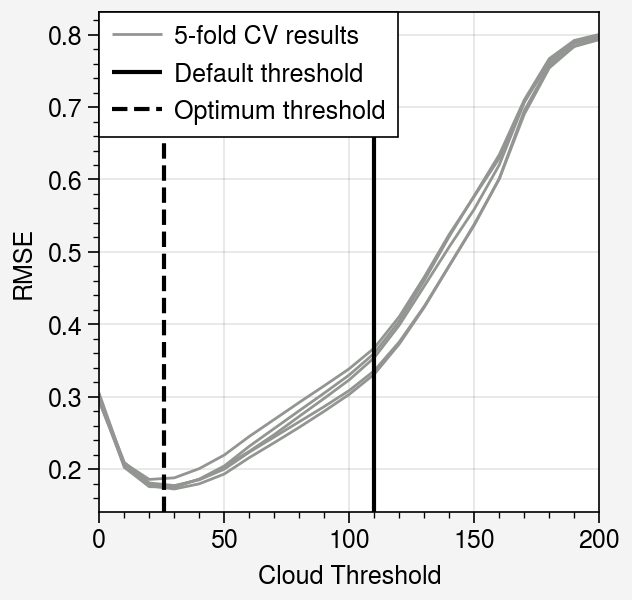

In [46]:
# Test version without splitting by regions to get syntax
fig, ax = pplt.subplots()
x_eval = np.linspace(TC.min(), TC.max(), 201)
results = []

# Initialize cross validation
# TBD: learn how to stratify within the K-fold samplng
kf = KFold(n_splits=5, random_state=20240126, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(df_training)):
    # first get the root mean square error as a function of TC
    rmse = np.sqrt(np.mean( df_training.iloc[train_index,:]**2, axis=0))
    
    # then find the minimum
    tc_optimal = pd.Series(interp1d(x=rmse.index, y=rmse.values, kind='quadratic')(x_eval), index=x_eval).idxmin()

    test_cases = df_training.iloc[test_index, :].index
    test_results = np.array([
        np.mean(fc_images[case][0,:,:] > tc_optimal) - df.loc[case, 'cloud_fraction_manual']
            for case in test_cases if case in fc_images])
    tc_rmse = np.sqrt(np.mean(test_results**2))
    results.append([tc_optimal, tc_rmse])
    
    ax.plot(rmse, label='', color='gray', lw=1) #label='k=' + str(i))
ax.plot([],[], color='gray', lw=1, label='5-fold CV results')
kfold_results = pd.DataFrame(results, columns=['TC', 'RMSE']).mean(axis=0).round(2)

ax.axvline(110, color='k', label='Default threshold')
ax.axvline(kfold_results['TC'], color='k', ls='--', label='Optimum threshold')
ax.format(ylabel='RMSE', xlabel='Cloud Threshold')
ax.legend(loc='ul', ncols=1, alpha=1)

# fig.save('../figures/cloud_fraction_calibration_manual.png', dpi=300)

In [47]:
kfold_results = pd.DataFrame(results, columns=['TC', 'RMSE'])
kfold_results

TC      RMSE
0  27.0  0.177157
1  25.0  0.189516
2  28.0  0.195304
3  27.0  0.183233
4  23.0  0.143688

In [49]:
TC = kfold_results.mean(axis=0).round()['TC']
kfold_results.mean(axis=0).round()

TC      26.0
RMSE     0.0
dtype: float64

In [50]:
# Error against the held-out data
tc = TC
test_results = np.array([
    np.mean(fc_images[case][0,:,:] > tc) - df.loc[case, 'cloud_fraction_manual']
        for case in df_testing.index if case in fc_images])
test_results = pd.Series(test_results, index=[case for case in df_testing.index if case in fc_images])
tc_rmse = np.sqrt(np.mean(test_results**2))
print('CF error:', np.round(tc_rmse, 3))

CF error: 0.22


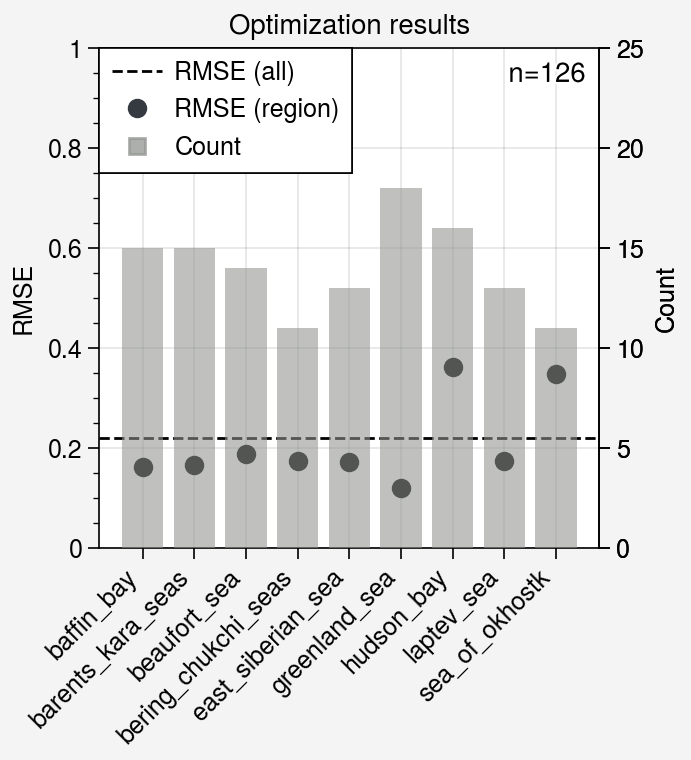

In [51]:
fig, ax = pplt.subplots()
ax.plot(
    test_results.groupby(df.loc[test_results.index, 'region']).apply(lambda x: np.sqrt(np.mean(x**2))),
    marker='o', lw=0, zorder=2, color='k')
ax.axhline(tc_rmse, color='k', ls='--', lw=1)
ax2 = ax.twinx()
ax2.bar(
    test_results.groupby(df.loc[test_results.index, 'region']).count(), zorder=0, color='gray', alpha=0.35
    )
ax2.format(ylabel='Count', ytickminor=False)

ax.format(xrotation=45, ylim=(0, 1), xlabel='', ylabel='RMSE', title='Optimization results')
ax.format(urtitle='n=' + str(len(test_results)))
ax2.format(ylim=(0, 25))
h = [ax.plot([],[],marker='', ls='--', color='k', lw=1),
     ax.plot([],[],marker='o', color='gray8', lw=0),
     ax.plot([],[],marker='s', color='gray', alpha=0.75, lw=0)]
ax2.legend(h, ['RMSE (all)', 'RMSE (region)', 'Count'], loc='ul', ncols=1, alpha=1)
# fig.save('../figures/cloud_fraction_validation_manual.png', dpi=300)

# Results
Based on the manual cloud fraction data, the optimal choice of the cloud threshold $T_C$ is 26, with an associated error of 20%. The visualization of the RMSE function for the 5-fold cross validation shows that the threshold choice varies only slightly between samples, and that the variability in RMSE abetween regions is not particularly large. Error is highest in the Beaufort Sea and lowest in the Barents-Kara Seas.

# Questions
- Is it better to over or underestimate cloud fraction?
- Is this low threshold overly aggressive?
- How does the error look spatially?
- How does the manual cloud fraction compare to the MODIS cloud mask, which is likely more precise?
- How does the manual cloud fraction compare with ERA5, CERES cloud fractions? (e.g.)
- Can I wrap together the parts of the k-fold validation using cleaner arrangements? E.g. using recommended functions from the docs.
- Is there a tendency toward a particular kind of error w/ e.g. thin clouds, land, different cloud fractions?

# Callibration using the MODIS cloud product


To calibrate the cloud mask against the MODIS cloud product, I translated the RGB data into percentages. The percentages are only known to the nearest ~16%. The percentage represent the number of pixels in a block that are flagged as clouds. The mean of the difference between the binary cloud-flagged pixels and the cloud fraction matrix is equal to the difference in mean cloud fraction.

For a matrix $A$ with binary data, we can think of it as consisting of blocks:
$$
\left[
\begin{matrix}
a_{00} & a_{01} \\
a_{10} & a_{11}
\end{matrix}
\right]
$$
where the individual blocks may look like
$$a_{00} = 
\left[
\begin{matrix}
 0 & 1 & 0 \\
 1 & 0 & 1 \\
 1 & 0 & 1 
\end{matrix}
\right]
$$
The mean of $a_{00}$ in this example is $\bar a = 5/9$. The cloud fractions from MODIS are going to be the same shape as the matrix, but with constant values within each block e.g.
$$b_{00} = 
\left[
\begin{matrix}
 f & f & f \\
 f & f & f \\
 f & f & f 
\end{matrix}
\right]
$$
Thus the mean of the block difference $a_{00} - b_{00}$ is simply the difference in fractions:
$$ \frac{1}{9}(-4f + 5(1-f)) = \frac{1}{9}(5 - 9f) = \bar a - f$$

If $f = \bar a$, then we have
$$\langle a_{00} - b_{00} \rangle = 0$$

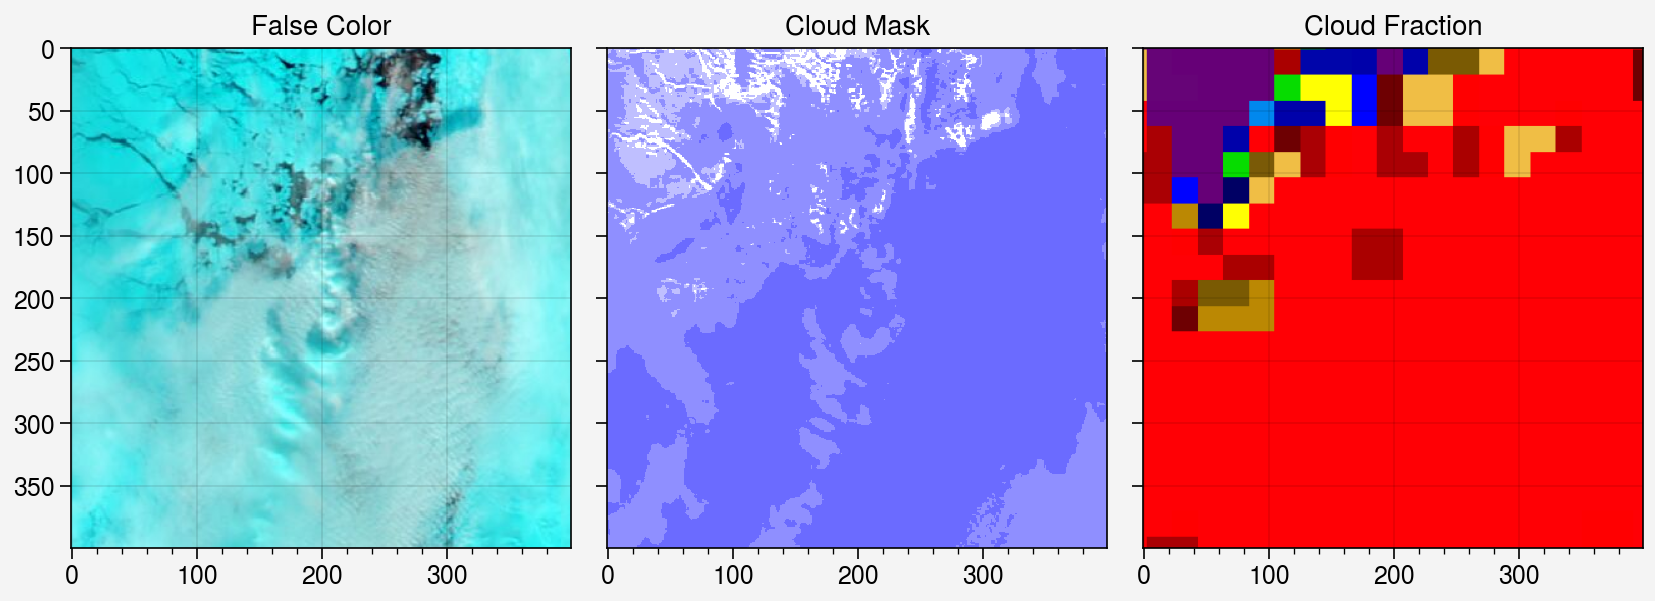

In [52]:
from rasterio.plot import reshape_as_image
fig, ax = pplt.subplots(ncols=3)
case = '021_aqua'

ax[0].imshow(reshape_as_image(fc_images[case]))
ax[2].imshow(reshape_as_image(cl_images[case]))

for tc in [14, 27, 110]:
    ax[1].pcolormesh(np.ma.masked_array((fc_images[case][0,:,:] > tc).astype(int), mask=fc_images[case][0,:,:] < tc), alpha=0.25, c='b') 
ax.format(ytickminor=False)
ax[0].format(title='False Color')
ax[1].format(title='Cloud Mask')
ax[2].format(title='Cloud Fraction')
fig.save('../figures/example_FC_CM_CF_image.png', dpi=300)

Using the MODIS cloud fraction data from the NASA snapshots
- RGB data needs to be translated into cloud fraction

In [64]:
import skimage
key = skimage.io.imread("../data/color_key.png")

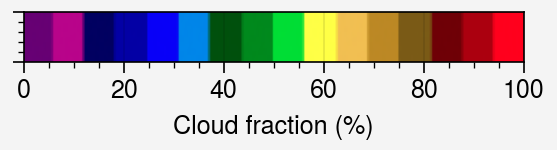

In [65]:
fig, ax = pplt.subplots()
ax.imshow(key, extent=[0, 100, 0, 10])
ax.format(yformatter='none', xlabel='Cloud fraction (%)')

This color bar goes from <5% to >95% cloud cover


In [66]:
vals = pd.DataFrame(np.mean(key[:, :, :-1], axis=0), columns=['r', 'g', 'b']).round(0).astype(int)

In the following figure, we see the column mean RGB intensities for each bin. They follow a clear stepwise pattern, with some noise and transition values. To get the midpoints, we recognize that there are 16 bin centers, and that the first bin starts at approximately the 6th column. We take a rolling mean, then slice in steps of size 14. The centers are shown by the vertical lines below.

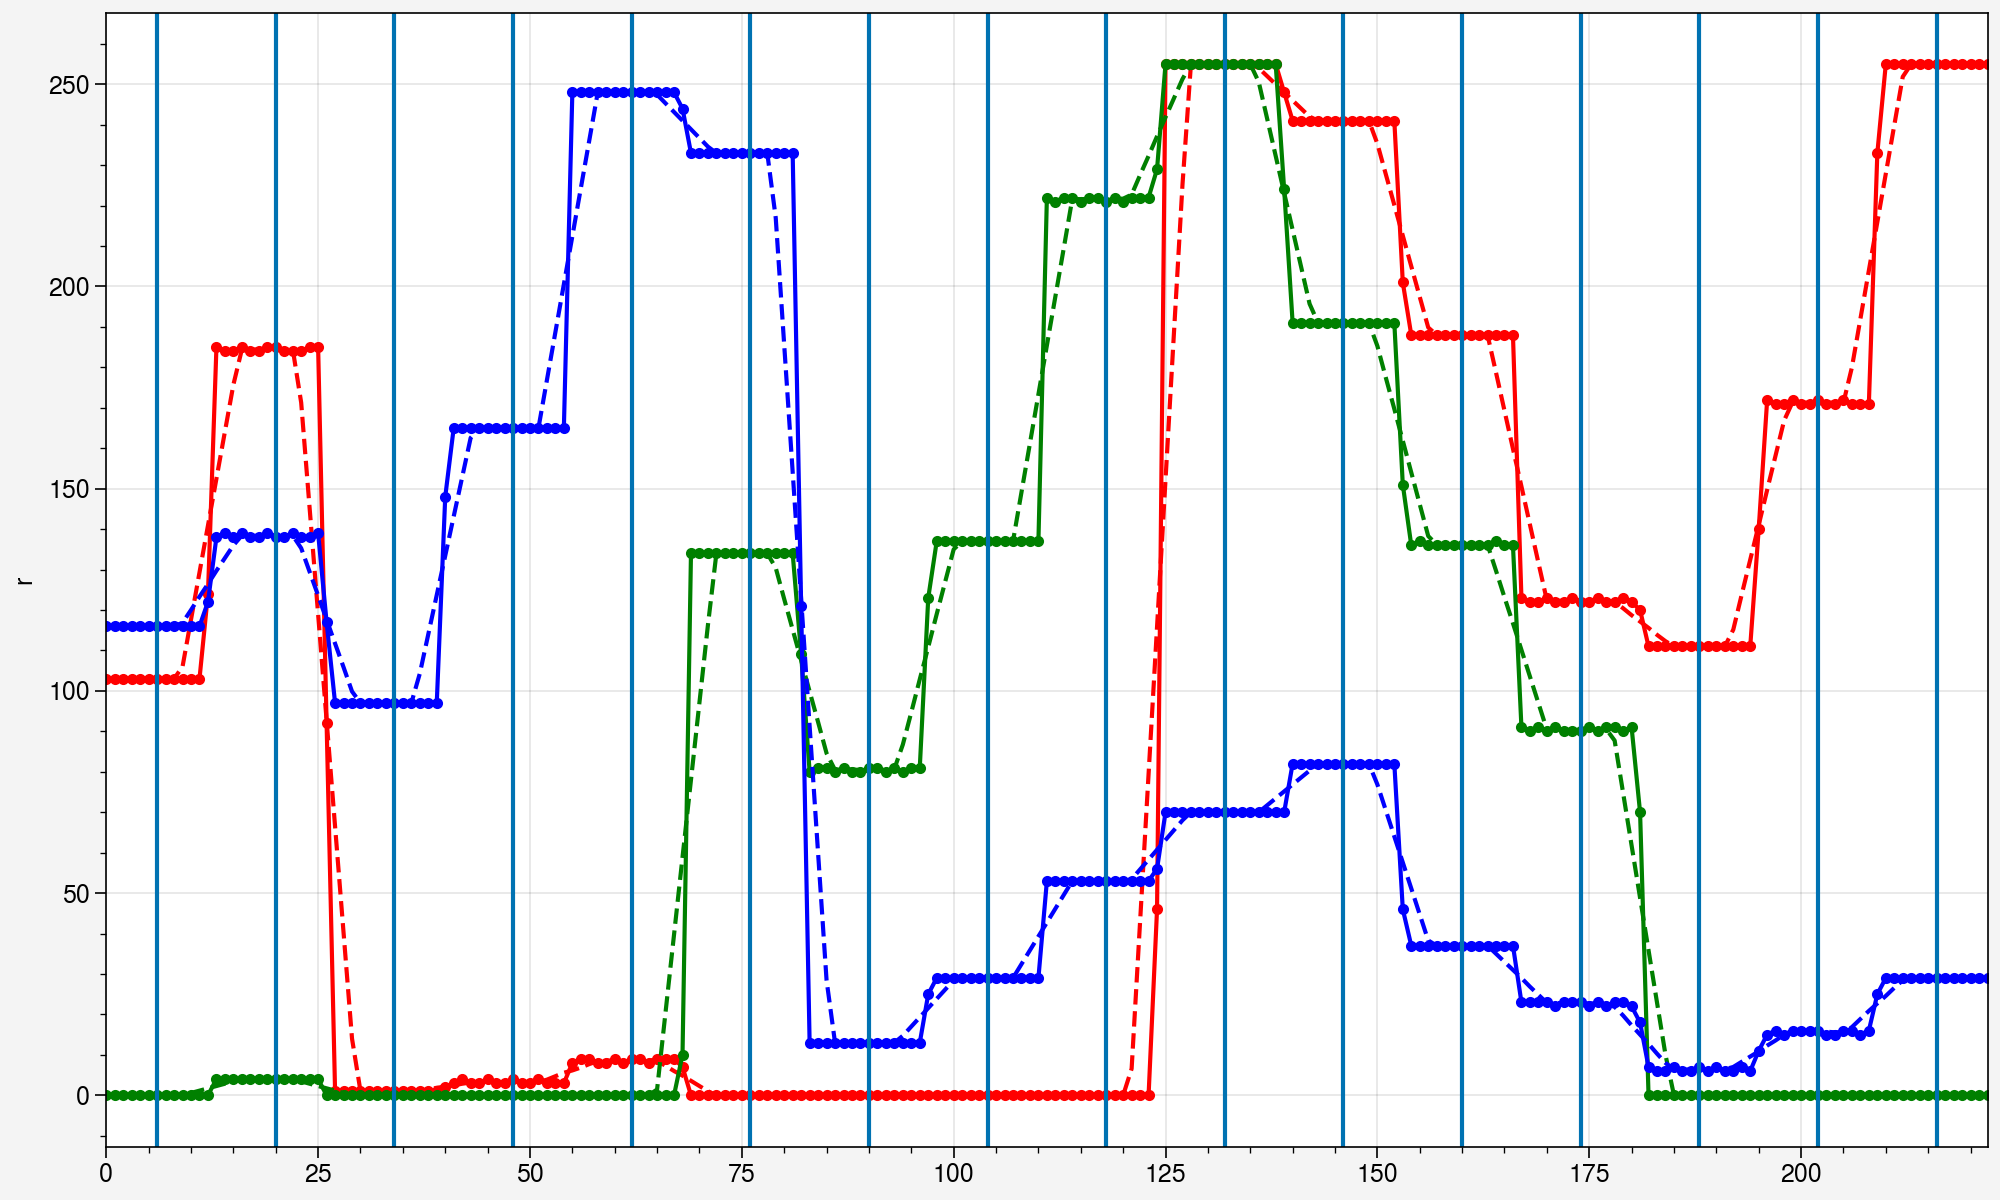

In [67]:
fig, ax = pplt.subplots(width=10, height=6)
vals2 = vals.rolling(7, center=True, min_periods=6).mean()
for c, channel in zip(['r', 'g', 'b'], range(3)):  
    ax.plot(vals[c], marker='.', color=c)
    ax.plot(vals2[c], color=c, ls='--')
for x in np.arange(6, len(vals), 14):
    ax.axvline(x)

In [68]:
bin_mean_values = vals2.iloc[6::14,:].astype(int)[['r', 'g', 'b']]

In [69]:
n = len(bin_mean_values)
print(n)
bin_edges = np.linspace(0, 100, n+1)
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
bin_mean_values.index = bin_centers

16


Our lookup table, with columns for RGB intensities and the cloud fraction they represent as the columns.

In [70]:
bin_mean_values

r    g    b
3.125   103    0  116
9.375   184    4  138
15.625    1    0   97
21.875    3    0  165
28.125    8    0  248
34.375    0  134  233
40.625    0   80   13
46.875    0  137   29
53.125    0  221   53
59.375  255  255   70
65.625  241  191   82
71.875  188  136   37
78.125  122   90   22
84.375  111    0    6
90.625  171    0   15
96.875  255    0   29

In [71]:
# Loop through images and translate into numerical values

In [5]:
cf_images = {}
cases = [c for c in cl_images]
cases.sort()

In [6]:
# Make the index of the df a unique case label
df.index = [x.case_number + '_' + x.satellite for row, x in df.iterrows()]

In [7]:
# Loading from file
cf_images = {}
for case in df.index:
    file = fname(df.loc[case], 'binary_landmask').replace('landmask.png', 'cloudfraction.csv')
    try:
        cf_images[case] = pd.read_csv("../data/cloudfraction_numeric/" + file, index_col=0) 
        cf_images[case].index = cf_images[case].index.astype(int)
        cf_images[case].columns = cf_images[case].columns.astype(int)
    except:
        print(case)

In [8]:
%%time
# Only run if needing to do it again -- takes a long time to run!
recompute = False
if recompute:
    for case in cases:
        if case not in cf_images:
            color_im = reshape_as_image(cl_images[case])
            cloudfrac_im = np.zeros((color_im.shape[0], color_im.shape[1]))
            for i in range(cloudfrac_im.shape[0]):
                for j in range(cloudfrac_im.shape[1]):
                    p = color_im[i, j, :-1]
                    cloudfrac_im[i, j] = np.sqrt(np.sum((bin_mean_values - p)**2, axis=1)).idxmin()
            print(case)
            cf_images[case] = cloudfrac_im
            
    for case in cf_images:
        file = fname(df.loc[case], 'binary_landmask').replace('landmask.png', 'cloudfraction.csv')
        pd.DataFrame(cf_images[case]).to_csv("../data/cloudfraction_numeric/" + file)            

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [9]:
df['cloud_fraction_modis'] = np.nan
for case in cf_images:
    df.loc[case, 'cloud_fraction_modis'] = np.mean(cf_images[case]/100)

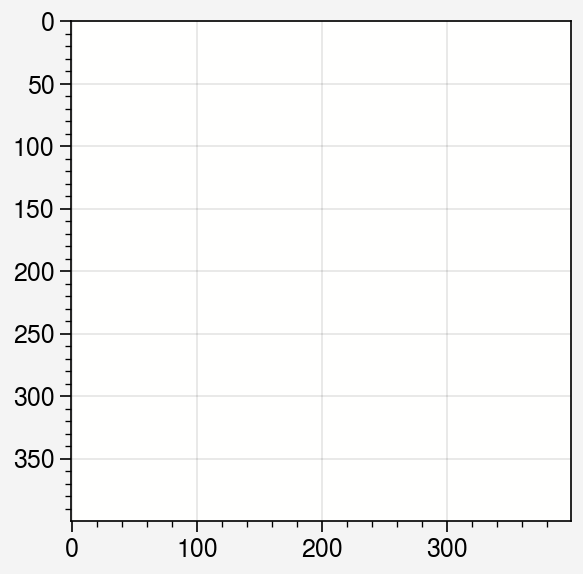

In [29]:
fig, ax = pplt.subplots()
ax.imshow(LM_modis.astype(int))

In [ ]:
from rasterio.plot import reshape_as_image
for case in cf_images:
    fig, ax = pplt.subplots(ncols=3, nrows=2)
    tc = 26
    ax[0,0].imshow(reshape_as_image(tc_images[case]))
    ax[0,1].imshow(reshape_as_image(fc_images[case]))
    ax[1,0].imshow(reshape_as_image(cl_images[case]))
    ax[0,2].pcolormesh((fc_images[case][0,:,:] > tc).astype(int), vmin=0, vmax=1) 
    ax[1,1].pcolormesh(cf_images[case], vmin=0, vmax=100, N=32, cmap='spectral_r', colorbar='r')

    # land mask
    # ice floes
    # land fast ice

    LM_modis = np.sum(lm_images[case], axis=0) > 0
    
    if case in lb_images:
        floes_manual = lb_images[case][0,:,:] > 0
        lfast_manual = lf_images[case][0,:,:] > 0
        masks = [LM_modis, floes_manual, lfast_manual]
        colors = ['k', 'r', 'gold']
    else:
        masks = [LM_modis]
        colors = ['k']
        
    for mask, color in zip(masks, colors):
        ax[1,2].imshow(np.ma.masked_array(mask.astype(int), 
                                          mask=~mask), c=color, vmin=0, vmax=1)

    
    ax.format(ytickminor=False)
    ax[0,0].format(title='True Color')
    ax[0,1].format(title='False Color')
    ax[0,2].format(title='Cloud Mask (Threshold=' + str(tc) + ')')
    ax[1,0].format(title='Cloud Fraction (RGB)')
    ax[1,1].format(title='Cloud Fraction (%)')
    ax[1,2].format(title='Labeled Masks')
    
    ax.format(suptitle='Case {c}, {r}, {d}'.format(c=df.loc[case, 'case_number'],
                                                   r=df.loc[case, 'region'].replace('_', ' ').title(),
                                                   d=df.loc[case, 'start_date'].strftime('%Y-%m-%d')))
    fig.save('../figures/cf_mask/threshold_{tc}/example_FC_CM_CF_image_{c}.png'.format(c=case, tc=tc), dpi=300)
    pplt.close(fig)

The MODIS cloud mask is designed to work well for the full Earth. It contains methods for adapting the modeled surface reflectance for snow and ice surfaces. It often does very well. We examined the cloud fraction in the images manually as well as using the MODIS cloud product. Most sea ice regions are pack ice (MIZ is a small fraction of the total sea ice area). Since ocean and ice are treated differently in the model used for the cloud fraction, it is not surprising that there are errors at the MIZ-ocean interface. Case 11 is a good example of this: the cloud mask is clearly highlighting regions of sea ice.

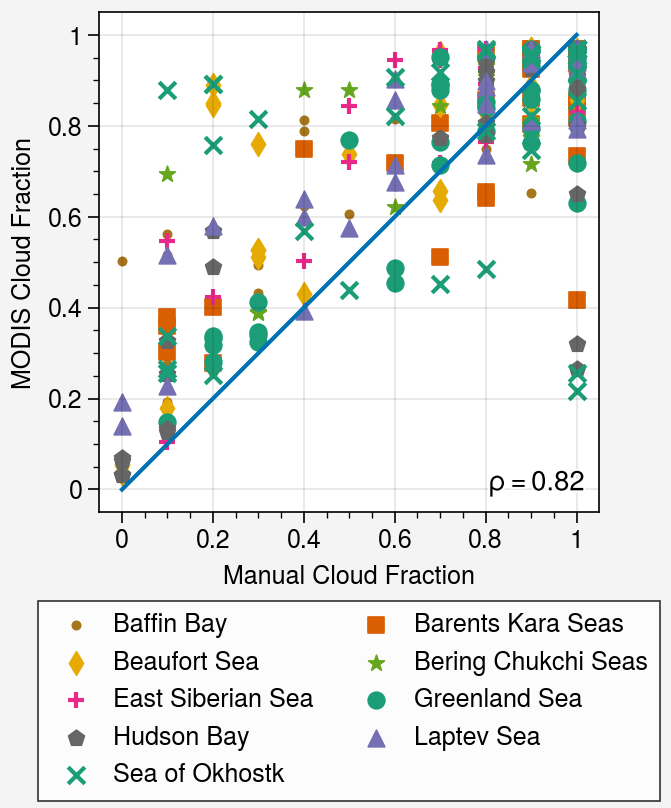

In [97]:
regions = pd.read_csv(dataloc + '/data/metadata/region_definitions.csv', index_col=0)

colors = {region: c['color'] for region, c in zip(
            regions.index,
            pplt.Cycle('dark2', len(regions)))}
markerstyles = {region: ls for region, ls in zip(regions.index,
                        ['o', 's', '^', '+', '*', 'd', '.', 'p', 'x'])}

regions['print_title'] = [c.replace('_', ' ').title().replace('Of', 'of') for c in regions.index]
regions = regions.sort_values('center_lon')


fig, ax = pplt.subplots()
for region, group in df.groupby('region'):
    
    ax.scatter(group['cloud_fraction_manual'], group['cloud_fraction_modis'], label=regions.loc[region, 'print_title'],
               m=markerstyles[region], color=colors[region])
ax.legend(loc='b', ncols=2)
ax.plot([0, 1], [0, 1])
ax.format(ylim=(-0.05, 1.05), xlim=(-0.05, 1.05), xlabel='Manual Cloud Fraction', ylabel='MODIS Cloud Fraction')
ax.format(lrtitle='$\\rho=$' + str(np.round(df['cloud_fraction_modis'].corr(df['cloud_fraction_manual']), 2)))
fig.save('../figures/manual_modis_cloud_comparison.png', dpi=300)

In [98]:
# Outliers
df.loc[np.abs((df.cloud_fraction_modis - df.cloud_fraction_manual)) > 0.5, ['region', 'cloud_fraction_modis', 'cloud_fraction_manual']]

region  cloud_fraction_modis  cloud_fraction_manual
011_aqua            baffin_bay              0.502147                    0.0
042_terra    barents_kara_seas              0.417928                    1.0
056_aqua          beaufort_sea              0.851230                    0.2
062_aqua          beaufort_sea              0.846695                    0.2
062_terra         beaufort_sea              0.890675                    0.2
071_terra  bering_chukchi_seas              0.695057                    0.1
133_aqua            hudson_bay              0.264140                    1.0
133_terra           hudson_bay              0.320153                    1.0
171_aqua        sea_of_okhostk              0.215661                    1.0
171_terra       sea_of_okhostk              0.255877                    1.0
179_aqua        sea_of_okhostk              0.815057                    0.3
179_terra       sea_of_okhostk              0.891299                    0.2
181_aqua        sea_of_okhostk              0.878736                    0.1
181_terra       sea_of_okhostk              0.891621                    0.2
183_aqua        sea_of_okhostk              0.756980                    0.2

# Finding optimal cloud fraction threshold, now with the MODIS cloud data
This method provides what I think is a reasonable start. However, what it fails to do is to compare _patterns_ of cloud cover. I've computed the cloud fraction for each image, and am looking at the difference in cloud fraction. This is different from computing the error pixel-by-pixel. I would need the cloud mask data rather than the aggregated cloud fraction data for that.

In [88]:
# Compute estimated cloud fraction for a range of threshold values
cloud_cases = df.dropna(subset='cloud_fraction_modis').index
TC = np.linspace(0, 200, 21)
df_est_tc = pd.DataFrame(index=cloud_cases,
                          columns=TC, data=np.nan)
# for each value, compute an estimated cloud fraction based on the fc_images
for tc in df_est_tc.columns:
    for case in df_est_tc.index:
        if case in fc_images:
            df_est_tc.loc[case, tc] = np.mean(fc_images[case][0,:,:] > tc)

# finally, calculate the difference between F and F_est
df_err = (df_est_tc.T - df.loc[cloud_cases, 'cloud_fraction_modis']).T
df_err = df_err.dropna()

In [89]:
df_est_tc.columns

Index([  0.0,  10.0,  20.0,  30.0,  40.0,  50.0,  60.0,  70.0,  80.0,  90.0,
       100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0, 190.0,
       200.0],
      dtype='float64')

In [90]:
df_training = df_err.sample(frac=2/3, replace=False, random_state=306)
df_testing = df_err.loc[[x for x in df_err.index if x not in df_training.index]]

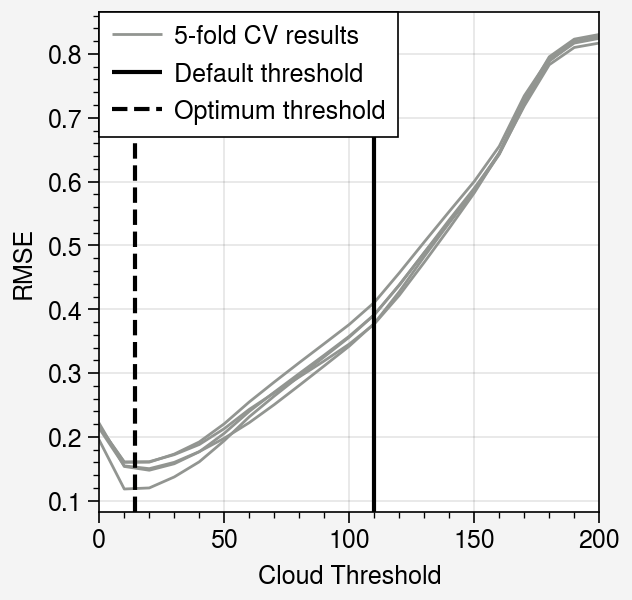

In [91]:
# Test version without splitting by regions to get syntax
fig, ax = pplt.subplots()
x_eval = np.linspace(TC.min(), TC.max(), 201)
results = []

# Initialize cross validation
# TBD: learn how to stratify within the K-fold samplng
kf = KFold(n_splits=5, random_state=20240126, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(df_training)):
    # first get the root mean square error as a function of TC
    rmse = np.sqrt(np.mean( df_training.iloc[train_index,:]**2, axis=0))
    
    # then find the minimum
    tc_optimal = pd.Series(interp1d(x=rmse.index, y=rmse.values, kind='quadratic')(x_eval), index=x_eval).idxmin()

    test_cases = df_training.iloc[test_index, :].index
    test_results = np.array([
        np.mean(fc_images[case][0,:,:] > tc_optimal) - df.loc[case, 'cloud_fraction_modis']
            for case in df_training.index])
    tc_rmse = np.sqrt(np.mean(test_results**2))
    results.append([tc_optimal, tc_rmse])
    
    ax.plot(rmse, label='', color='gray', lw=1) #label='k=' + str(i))
ax.plot([],[], color='gray', lw=1, label='5-fold CV results')
kfold_results = pd.DataFrame(results, columns=['TC', 'RMSE']).mean(axis=0).round(2)

ax.axvline(110, color='k', label='Default threshold')
ax.axvline(kfold_results['TC'], color='k', ls='--', label='Optimum threshold')
ax.format(ylabel='RMSE', xlabel='Cloud Threshold')
ax.legend(loc='ul', ncols=1, alpha=1)

# fig.save('../figures/cloud_fraction_calibration_modis.png', dpi=300)

In [92]:
kfold_results = pd.DataFrame(results, columns=['TC', 'RMSE'])
kfold_results

TC      RMSE
0  15.0  0.147433
1  14.0  0.147676
2  15.0  0.147433
3  14.0  0.147676
4  14.0  0.147676

In [93]:
kfold_results.mean(axis=0).round(2)

TC      14.40
RMSE     0.15
dtype: float64

In [94]:
# Error against the held-out data
tc = 14
test_results = np.array([
    np.mean(fc_images[case][0,:,:] > tc) - df.loc[case, 'cloud_fraction_modis']
        for case in df_testing.index])
test_results = pd.Series(test_results, index=df_testing.index)
tc_rmse = np.sqrt(np.mean(test_results**2))
print('CF error:', np.round(tc_rmse, 3))

CF error: 0.133


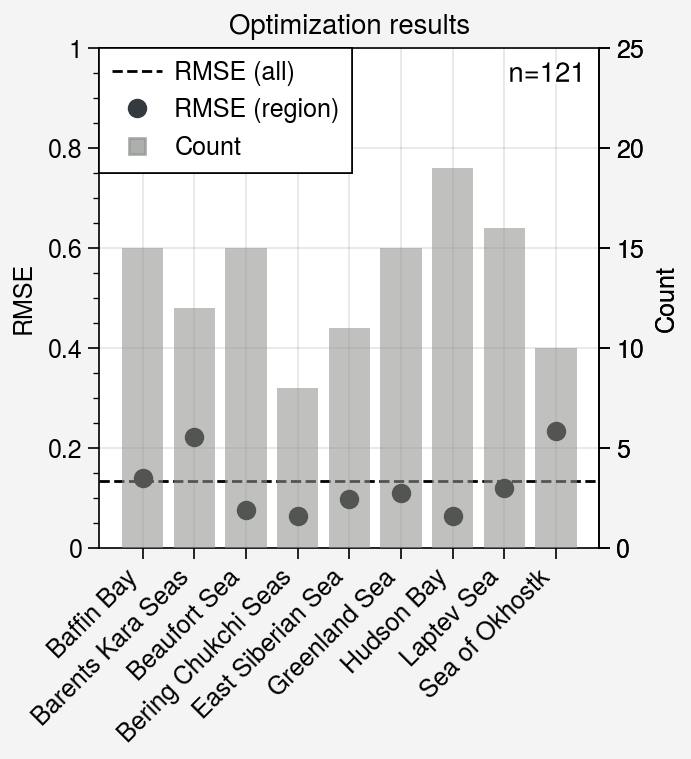

In [95]:
fig, ax = pplt.subplots()
ax.plot(
    test_results.groupby(df.loc[test_results.index, 'region']).apply(lambda x: np.sqrt(np.mean(x**2))),
    marker='o', lw=0, zorder=2, color='k')
ax.axhline(tc_rmse, color='k', ls='--', lw=1)
ax2 = ax.twinx()
plot_data = test_results.groupby(df.loc[test_results.index, 'region']).count()
plot_data.index = [x.replace('_', ' ').title().replace('Of', 'of') for x in plot_data.index]

ax2.bar(
    plot_data, zorder=0, color='gray', alpha=0.35
    )
ax2.format(ylabel='Count', ytickminor=False)

ax.format(xrotation=45, ylim=(0, 1), xlabel='', ylabel='RMSE', title='Optimization results')
ax.format(urtitle='n=' + str(len(test_results)))
ax2.format(ylim=(0, 25))
h = [ax.plot([],[],marker='', ls='--', color='k', lw=1),
     ax.plot([],[],marker='o', color='gray8', lw=0),
     ax.plot([],[],marker='s', color='gray', alpha=0.75, lw=0)]
ax2.legend(h, ['RMSE (all)', 'RMSE (region)', 'Count'], loc='ul', ncols=1, alpha=1)
# fig.save('../figures/cloud_fraction_validation_modis.png', dpi=300)

# Pixel unmasking: identifying optically thin clouds
The original algorithm is
1. Mask all pixels with $l_1 > 110 = T_C$.
2. Unmask pixels with $l_1 < 200 = T_1$ and $l_2 > 190 = T_2$.
3. Unmask pixels with $l_1/l_2 < 0.75 = R_{1,2}$.

In the prior sections, we have found that the first step underestimates the total cloud cover (noting, however, that this high threshold was set just to mask the clouds with the highest opacity). To identify the thin clouds, we have three parameters to adjust, making the optimization a bit more challenging. 



Parameters to optimize over
1. $T_1$. Operates on channel 1.
2. $T_2$. Operates on channel 2.
3. $R_{1,2}$. Ratio of $T_1$ and $T_2$. Pixels with $R_{1,2}$ less than the threshold are unmasked.
Point of clarification for the cloud mask: 1 and 2 are an intersection, so they can really only be varied together.  For the ratio, is this additional unmasking or a conditional on the prior conditions?

The `mask_cloud_ice` variable 

In [96]:
case = '152_aqua'

T1 = 160
T2 = 200
R_lower = 0
R_upper = 0.6
tc = 27

clouds_view = fc_images[case][0,:,:] > tc # true == cloudy pixel
mask_b7b2 = (fc_images[case][0,:,:] < T1) & (fc_images[case][1,:,:] > T2) # true == thin cloud
mask_ratio = fc_images[case][0,:,:]/fc_images[case][1,:,:]
mask_cloud_ice = (mask_ratio > R_lower) & (mask_ratio < R_upper)
mask_cloud_ice = mask_cloud_ice & mask_b7b2
cloud_mask = ~(mask_cloud_ice | ~clouds_view)

/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_10988/80420904.py:11: RuntimeWarning: divide by zero encountered in divide
  mask_ratio = fc_images[case][0,:,:]/fc_images[case][1,:,:]
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_10988/80420904.py:11: RuntimeWarning: invalid value encountered in divide
  mask_ratio = fc_images[case][0,:,:]/fc_images[case][1,:,:]


In [105]:
def generate_masks(fc_image, t1, t2, r_lower, r_upper, tc):
    """Generate the all-cloud and opaque-cloud masks. Opaque cloud mask is defined as a subset
    of the all-cloud mask where the ice floes are visible."""
    clouds_view = fc_image[0,:,:] > tc # true == cloudy pixel
    mask_b7b2 = (fc_image[0,:,:] < t1) & (fc_image[1,:,:] > t2) # true == thin cloud
    mask_ratio = fc_image[0,:,:]/fc_image[1,:,:]
    mask_cloud_ice = (mask_ratio > r_lower) & (mask_ratio < r_upper)
    mask_cloud_ice = mask_cloud_ice & mask_b7b2
    cloud_mask = ~(mask_cloud_ice | ~clouds_view)
    return clouds_view, cloud_mask

In [106]:
def cloud_fraction_loss_function(new_mask, old_mask):
    """Relative change in cloud fraction against the old mask.
    If no clouds, then return 0. New mask should be 1 where there are clouds."""

    cf_new = np.mean(new_mask)
    cf_old = np.mean(old_mask)
    if cf_old > 1e-4:
        return (cf_old - cf_new)/cf_old
    else:
        return 0

def sea_ice_fraction_loss_function(new_mask, sea_ice_labels):
    """Relative decrease in sea ice cover from ground truth (sea_ice_labels) to the new_mask.
    If no sea ice, return 0"""

    sea_ice = np.sum(sea_ice_labels > 0)
    if sea_ice == 0:
        return 0

    uncovered_ice = np.sum((sea_ice_labels > 0) & ~new_mask)
    return (sea_ice - uncovered_ice)/sea_ice


/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/4070359669.py:13: RuntimeWarning: divide by zero encountered in divide
  mask_ratio = b7/b2
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/4070359669.py:13: RuntimeWarning: invalid value encountered in divide
  mask_ratio = b7/b2
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/1523296688.py:6: RuntimeWarning: divide by zero encountered in divide
  mask_ratio = fc_image[0,:,:]/fc_image[1,:,:]
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/1523296688.py:6: RuntimeWarning: invalid value encountered in divide
  mask_ratio = fc_image[0,:,:]/fc_image[1,:,:]
/opt/homebrew/Caskroom/miniconda/base/envs/calval/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


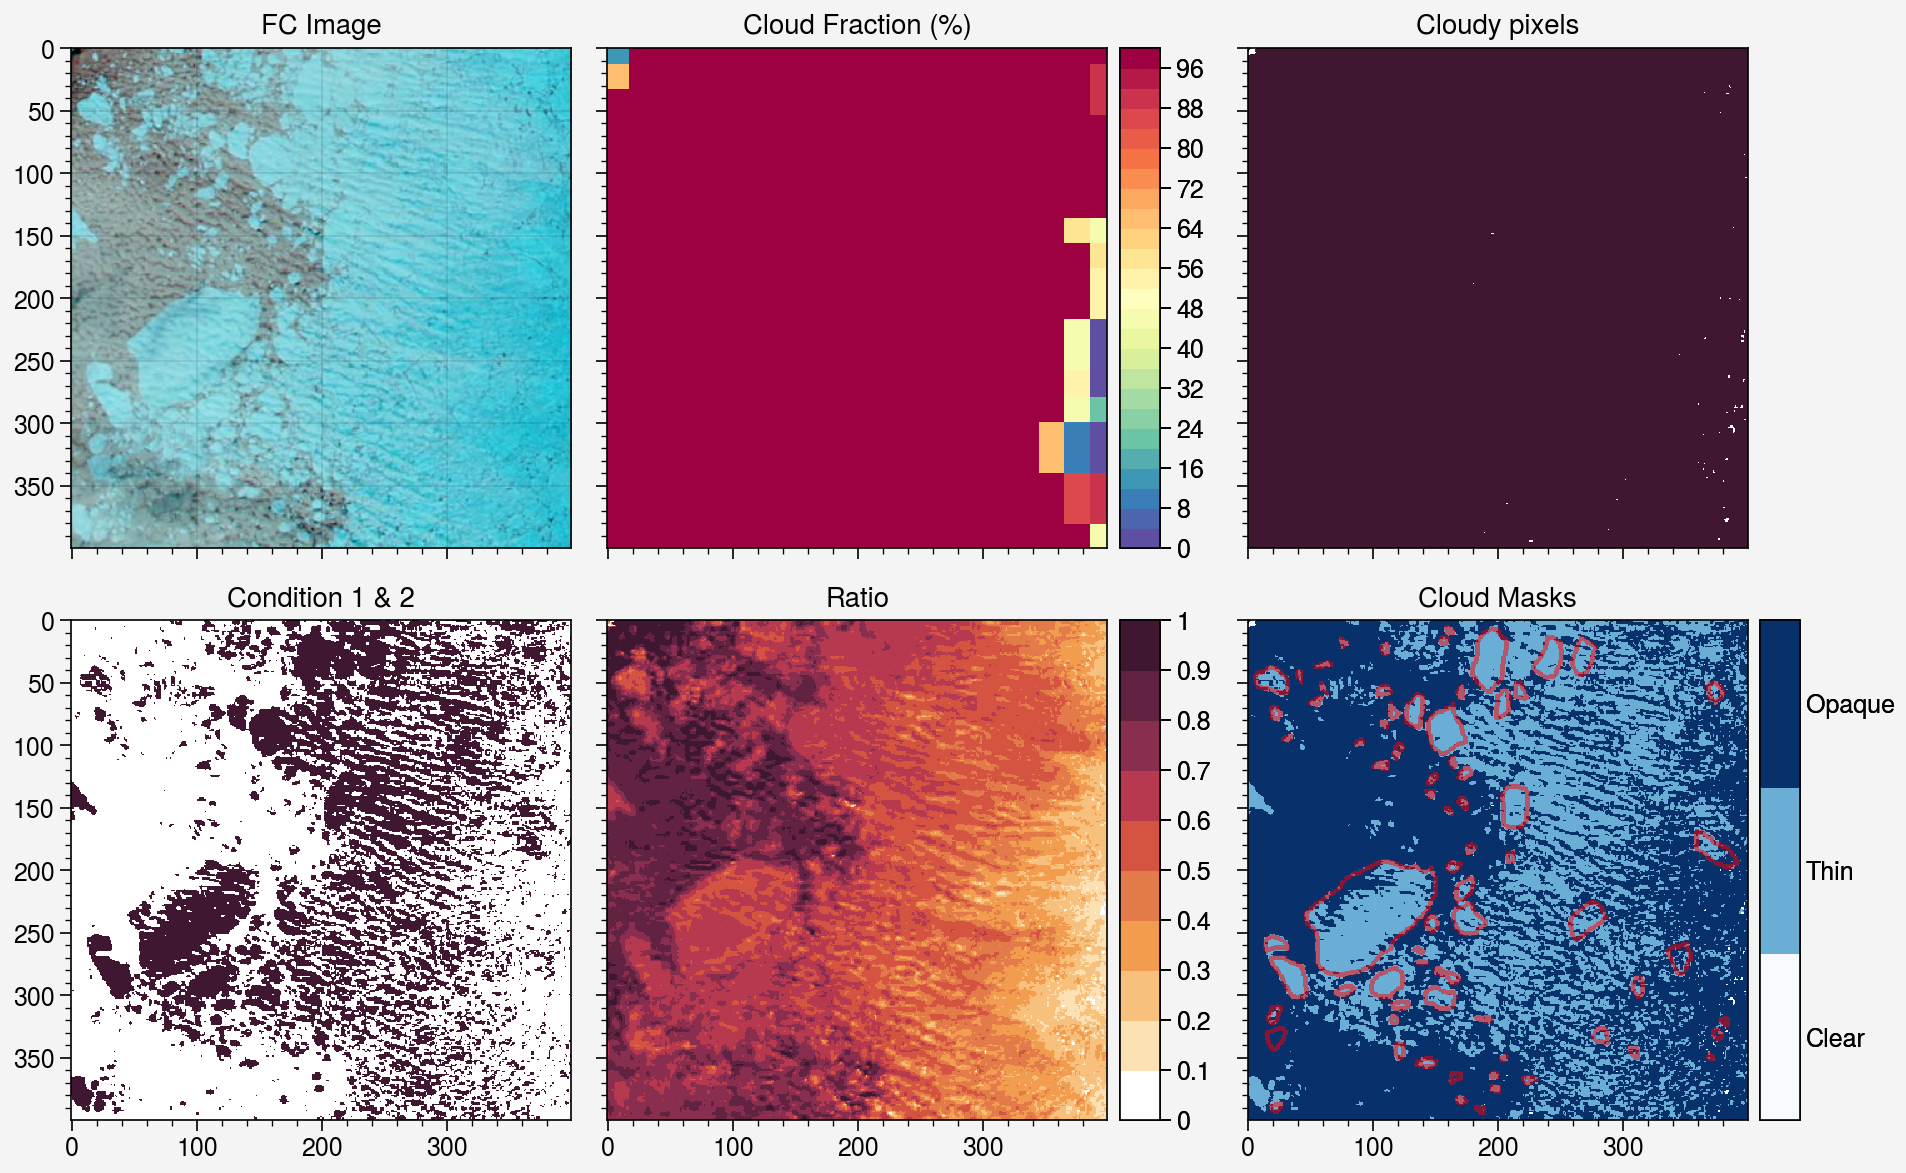

In [107]:
case = '019_aqua'
T1 = 190
T2 = 200
R_lower = 0
R_upper = 0.75
tc = 14

# clouds_view = fc_images[case][0,:,:] > tc # true == cloudy pixel
b7 = fc_images[case][0,:,:]
b2 = fc_images[case][1,:,:]

mask_b7b2 = (b7 < T1) & (b2 > T2) # true == thin cloud
mask_ratio = b7/b2
mask_cloud_ice = (mask_ratio > R_lower) & (mask_ratio < R_upper)
mask_cloud_ice = mask_cloud_ice & mask_b7b2
clouds_view, cloud_mask = generate_masks(fc_images[case], t1=T1, t2=T2, r_lower=0, r_upper=R_upper, tc=tc)

fig, axs = pplt.subplots(ncols=3, nrows=2)
layered_mask = ((cloud_mask).astype(float) + clouds_view.astype(float))/2
for ax, data, title in zip(axs, [fc_images[case], cf_images[case], clouds_view, mask_b7b2, mask_ratio, layered_mask],
                          ['FC Image', 'Cloud Fraction (%)', 'Cloudy pixels', 'Condition 1 & 2', 'Ratio', 'Cloud Masks']):
    if title == 'FC Image':
        ax.imshow(reshape_as_image(data))
    elif title == 'Cloud Fraction (%)':
        ax.pcolormesh(data.values, vmin=0, vmax=100, N=32, cmap='spectral_r', colorbar='r')
    else:
        c = ax.pcolormesh(data, vmin=0, vmax=1)
        if title=='Ratio':
            ax.colorbar(c, loc='r')
        if title=='Cloud Masks':
            c = ax.pcolormesh(data, N=3, cmap='blues')
            ax.colorbar(c, ticks=[.2, 0.6, 1], ticklabels=['Clear', 'Thin', 'Opaque'], ticklen=0.1)

    ax.format(title=title, yreverse=True)
manual_floe_labels = lb_images[case][0,:,:] % 2

outlines = manual_floe_labels - skimage.morphology.erosion(manual_floe_labels, skimage.morphology.disk(4))
axs[1, 2].pcolormesh(np.ma.masked_array(outlines, outlines==0), color='r', alpha=0.5)


axs.format(yreverse=True)
# axs[1,1].format(yreverse=True)

The calibration in this section aims to minimize the reduction in the cloud mask while maximizing the fraction of manually-labeled ice floes that are uncovered. A big challenge here is that the images vary quite a bit in the number of ice floes. It is not obvious how we should weight the results, whether by pixels or what.

In [115]:
lb_images.keys()

dict_keys(['001_terra', '001_aqua', '004_terra', '004_aqua', '005_terra', '005_aqua', '006_terra', '006_aqua', '007_aqua', '007_terra', '008_terra', '008_aqua', '009_terra', '009_aqua', '010_terra', '010_aqua', '011_aqua', '011_terra', '012_terra', '012_aqua', '013_aqua', '013_terra', '015_terra', '015_aqua', '016_terra', '016_aqua', '019_terra', '019_aqua', '021_terra', '021_aqua', '022_aqua', '022_terra', '023_aqua', '023_terra', '029_aqua', '029_terra', '033_aqua', '033_terra', '036_aqua', '036_terra', '043_aqua', '043_terra', '044_aqua', '044_terra', '046_aqua', '046_terra', '047_aqua', '047_terra', '048_aqua', '048_terra', '051_aqua', '051_terra', '053_aqua', '053_terra', '056_aqua', '056_terra', '062_aqua', '062_terra', '065_aqua', '065_terra', '067_aqua', '067_terra', '068_aqua', '068_terra', '069_aqua', '069_terra', '071_aqua', '071_terra', '075_aqua', '075_terra', '081_aqua', '081_terra', '086_aqua', '086_terra', '087_aqua', '087_terra', '093_aqua', '093_terra', '095_aqua', '0

/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/1393491453.py:16: RuntimeWarning: divide by zero encountered in divide
  nsdii2 = (b4 - b2)/(b4 + b2)
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/1393491453.py:16: RuntimeWarning: invalid value encountered in divide
  nsdii2 = (b4 - b2)/(b4 + b2)
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/1393491453.py:19: RuntimeWarning: divide by zero encountered in divide
  mask_ratio = b7/b2
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/1393491453.py:19: RuntimeWarning: invalid value encountered in divide
  mask_ratio = b7/b2
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/1523296688.py:6: RuntimeWarning: divide by zero encountered in divide
  mask_ratio = fc_image[0,:,:]/fc_image[1,:,:]
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/1523296688.py:6: RuntimeWarning: invalid value encountered in divide
  mask_ratio = fc_image[0,:,:]/fc_imag

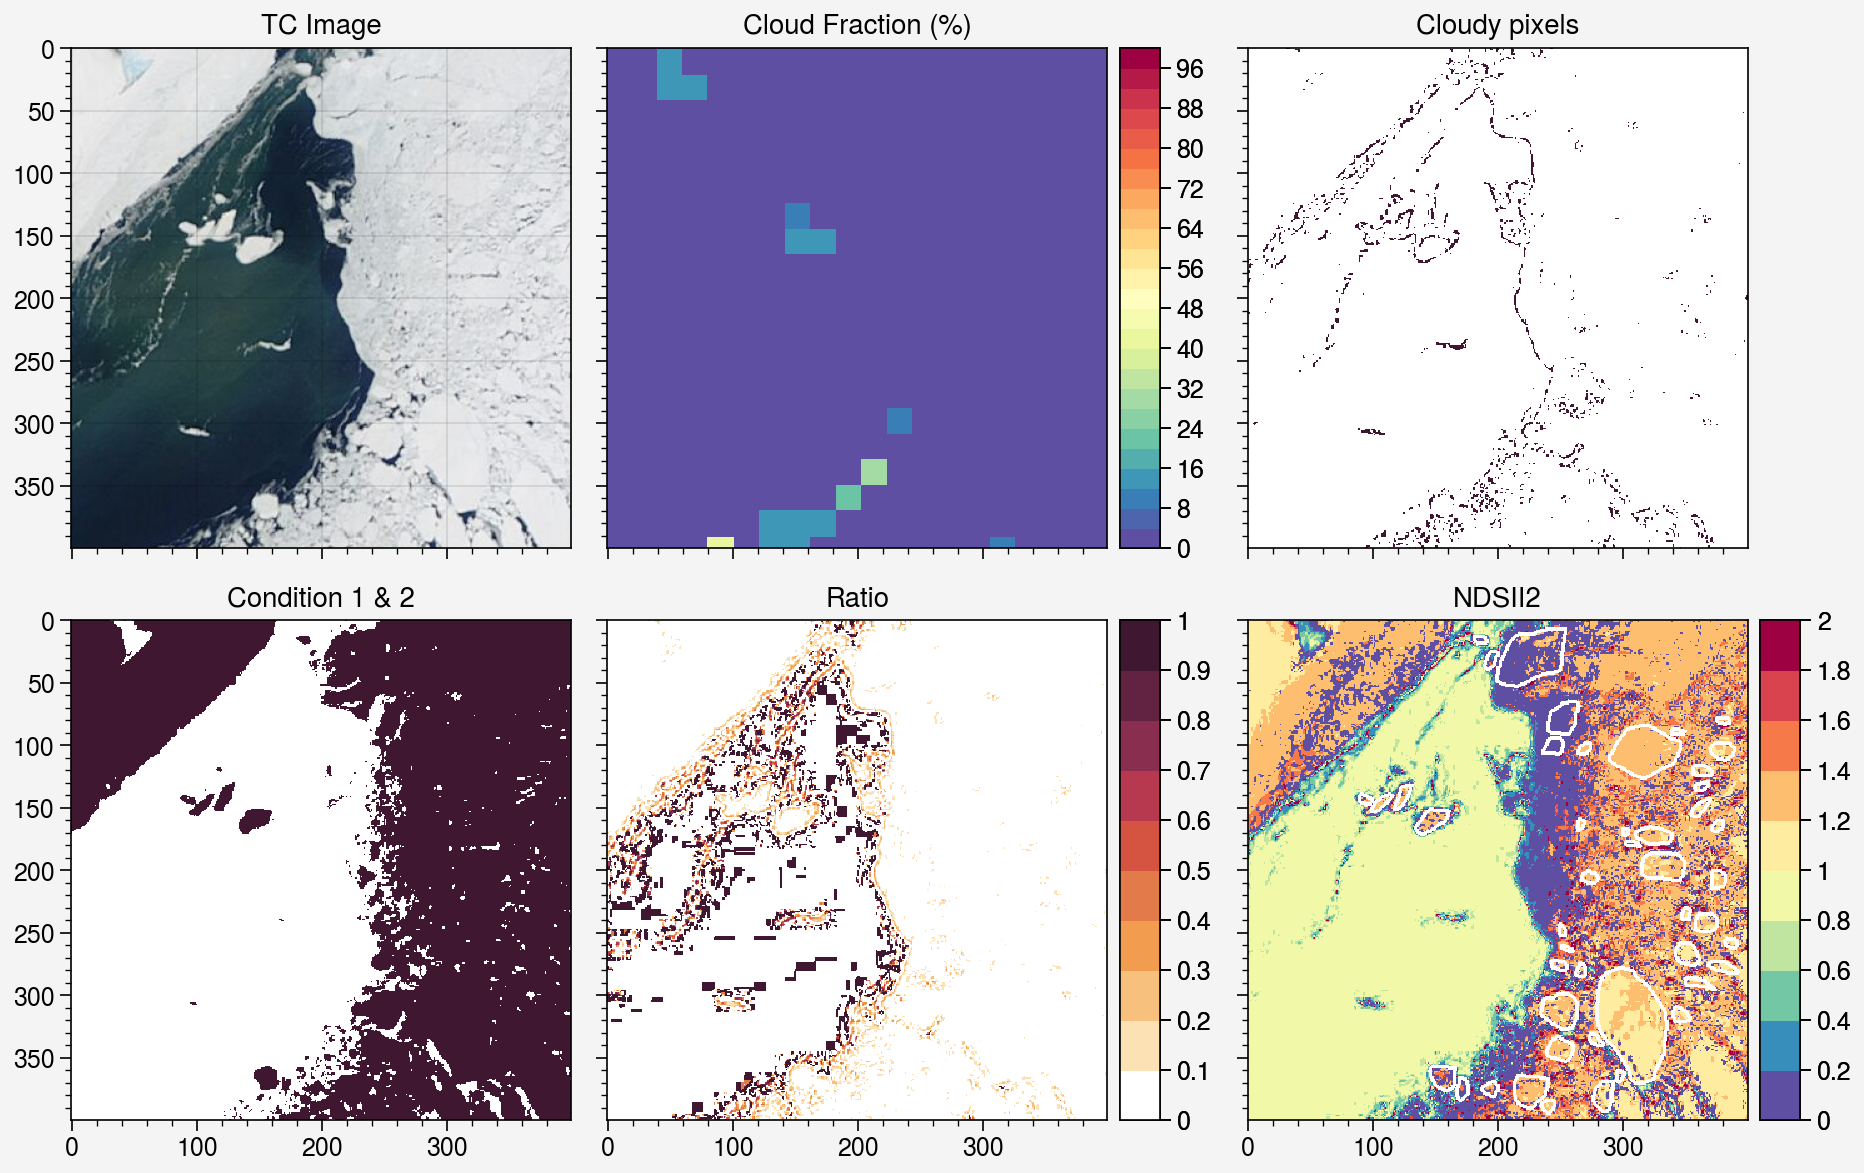

In [338]:
case = '081_aqua'
case = '019_aqua'
case = '048_terra'
T1 = 190
T2 = 200
R_lower = 0
R_upper = 0.75
tc = 26

# clouds_view = fc_images[case][0,:,:] > tc # true == cloudy pixel
b4 = tc_images[case][1,:,:]

b7 = fc_images[case][0,:,:]
b2 = fc_images[case][1,:,:]

nsdii2 = (b4 - b2)/(b4 + b2)

mask_b7b2 = (b7 < T1) & (b2 > T2) # true == thin cloud
mask_ratio = b7/b2
mask_cloud_ice = (mask_ratio > R_lower) & (mask_ratio < R_upper)
mask_cloud_ice = mask_cloud_ice & mask_b7b2
clouds_view, cloud_mask = generate_masks(fc_images[case], t1=T1, t2=T2, r_lower=0, r_upper=R_upper, tc=tc)

fig, axs = pplt.subplots(ncols=3, nrows=2)
layered_mask = ((cloud_mask).astype(float) + clouds_view.astype(float))/2
for ax, data, title in zip(axs, [tc_images[case], cf_images[case], clouds_view, mask_b7b2, mask_ratio, nsdii2],
                          ['TC Image', 'Cloud Fraction (%)', 'Cloudy pixels', 'Condition 1 & 2', 'Ratio', 'NDSII2']):
    if title == 'TC Image':
        ax.imshow(reshape_as_image(data))
    elif title == 'Cloud Fraction (%)':
        ax.pcolormesh(data.values, vmin=0, vmax=100, N=32, cmap='spectral_r', colorbar='r')
    else:
        c = ax.pcolormesh(data, N=10, vmin=0, vmax=1)
        if title=='Ratio':
            ax.colorbar(c, loc='r')
        if title=='NDSII2':
            c = ax.pcolormesh(data, N=10, vmin=0, vmax=2, cmap='spectral_r')
            ax.colorbar(c)

    ax.format(title=title, yreverse=True)
manual_floe_labels = lb_images[case][0,:,:] % 2

outlines = manual_floe_labels - skimage.morphology.erosion(manual_floe_labels, skimage.morphology.disk(2))
axs[1, 2].pcolormesh(np.ma.masked_array(outlines, outlines==0), color='w', alpha=1)


axs.format(yreverse=True)
# axs[1,1].format(yreverse=True)

# Selecting reference regions for pixel thresholds
1. Using MASIE ice and land to find open water

In [280]:
LM_modis.shape


(400, 400, 4)

In [335]:
for case in lb_images:
    TC = reshape_as_image(tc_images[case])
    FC = reshape_as_image(fc_images[case])
    LM_modis = np.sum(lm_images[case], axis=0) > 0
    LM_masie = reshape_as_image(ml_images[case])
    SI_masie = reshape_as_image(mi_images[case])
    
    floes_manual = lb_images[case][0,:,:] > 0
    lfast_manual = lf_images[case][0,:,:] > 0
    
    fig, ax = pplt.subplots(ncols=3)
    ax[0].imshow(TC)
    ax[1].imshow(FC)
    ax[2].imshow(np.ma.masked_array(LM_modis, mask=~LM_modis), c='k')
    ax[2].imshow(np.ma.masked_array(SI_masie, mask=SI_masie <= 1), c='b', alpha=0.5)
    ax[2].imshow(np.ma.masked_array(floes_manual, mask=floes_manual == 0), c='r', alpha=0.5)
    ax[2].imshow(np.ma.masked_array(lfast_manual, mask=lfast_manual == 0), c='gold', alpha=0.5)
    h = []
    for color in ['k', 'b', 'r', 'gold']:
        h.append(ax[2].plot([],[],lw=0, m='s',  c=color, alpha=0.5))
    ax[2].legend(h, ['landmask', 'masie ice', 'manual floes', 'manual landfast'], loc='r', ncols=1)
    
    ax.format(suptitle=case)
    ax[0].format(title='Truecolor')
    ax[1].format(title='Falsecolor')
    ax[2].format(title='Classification')
    fig.save('../figures/test_labels/' + case + '_tc_fc_labels.png', dpi=300)
    pplt.close(fig)

/opt/homebrew/Caskroom/miniconda/base/envs/calval/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/opt/homebrew/Caskroom/miniconda/base/envs/calval/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/opt/homebrew/Caskroom/miniconda/base/envs/calval/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/opt/homebrew/Caskroom/miniconda/base/envs/calval/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/opt/homebrew/Caskroom/miniconda/base/envs/calval/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


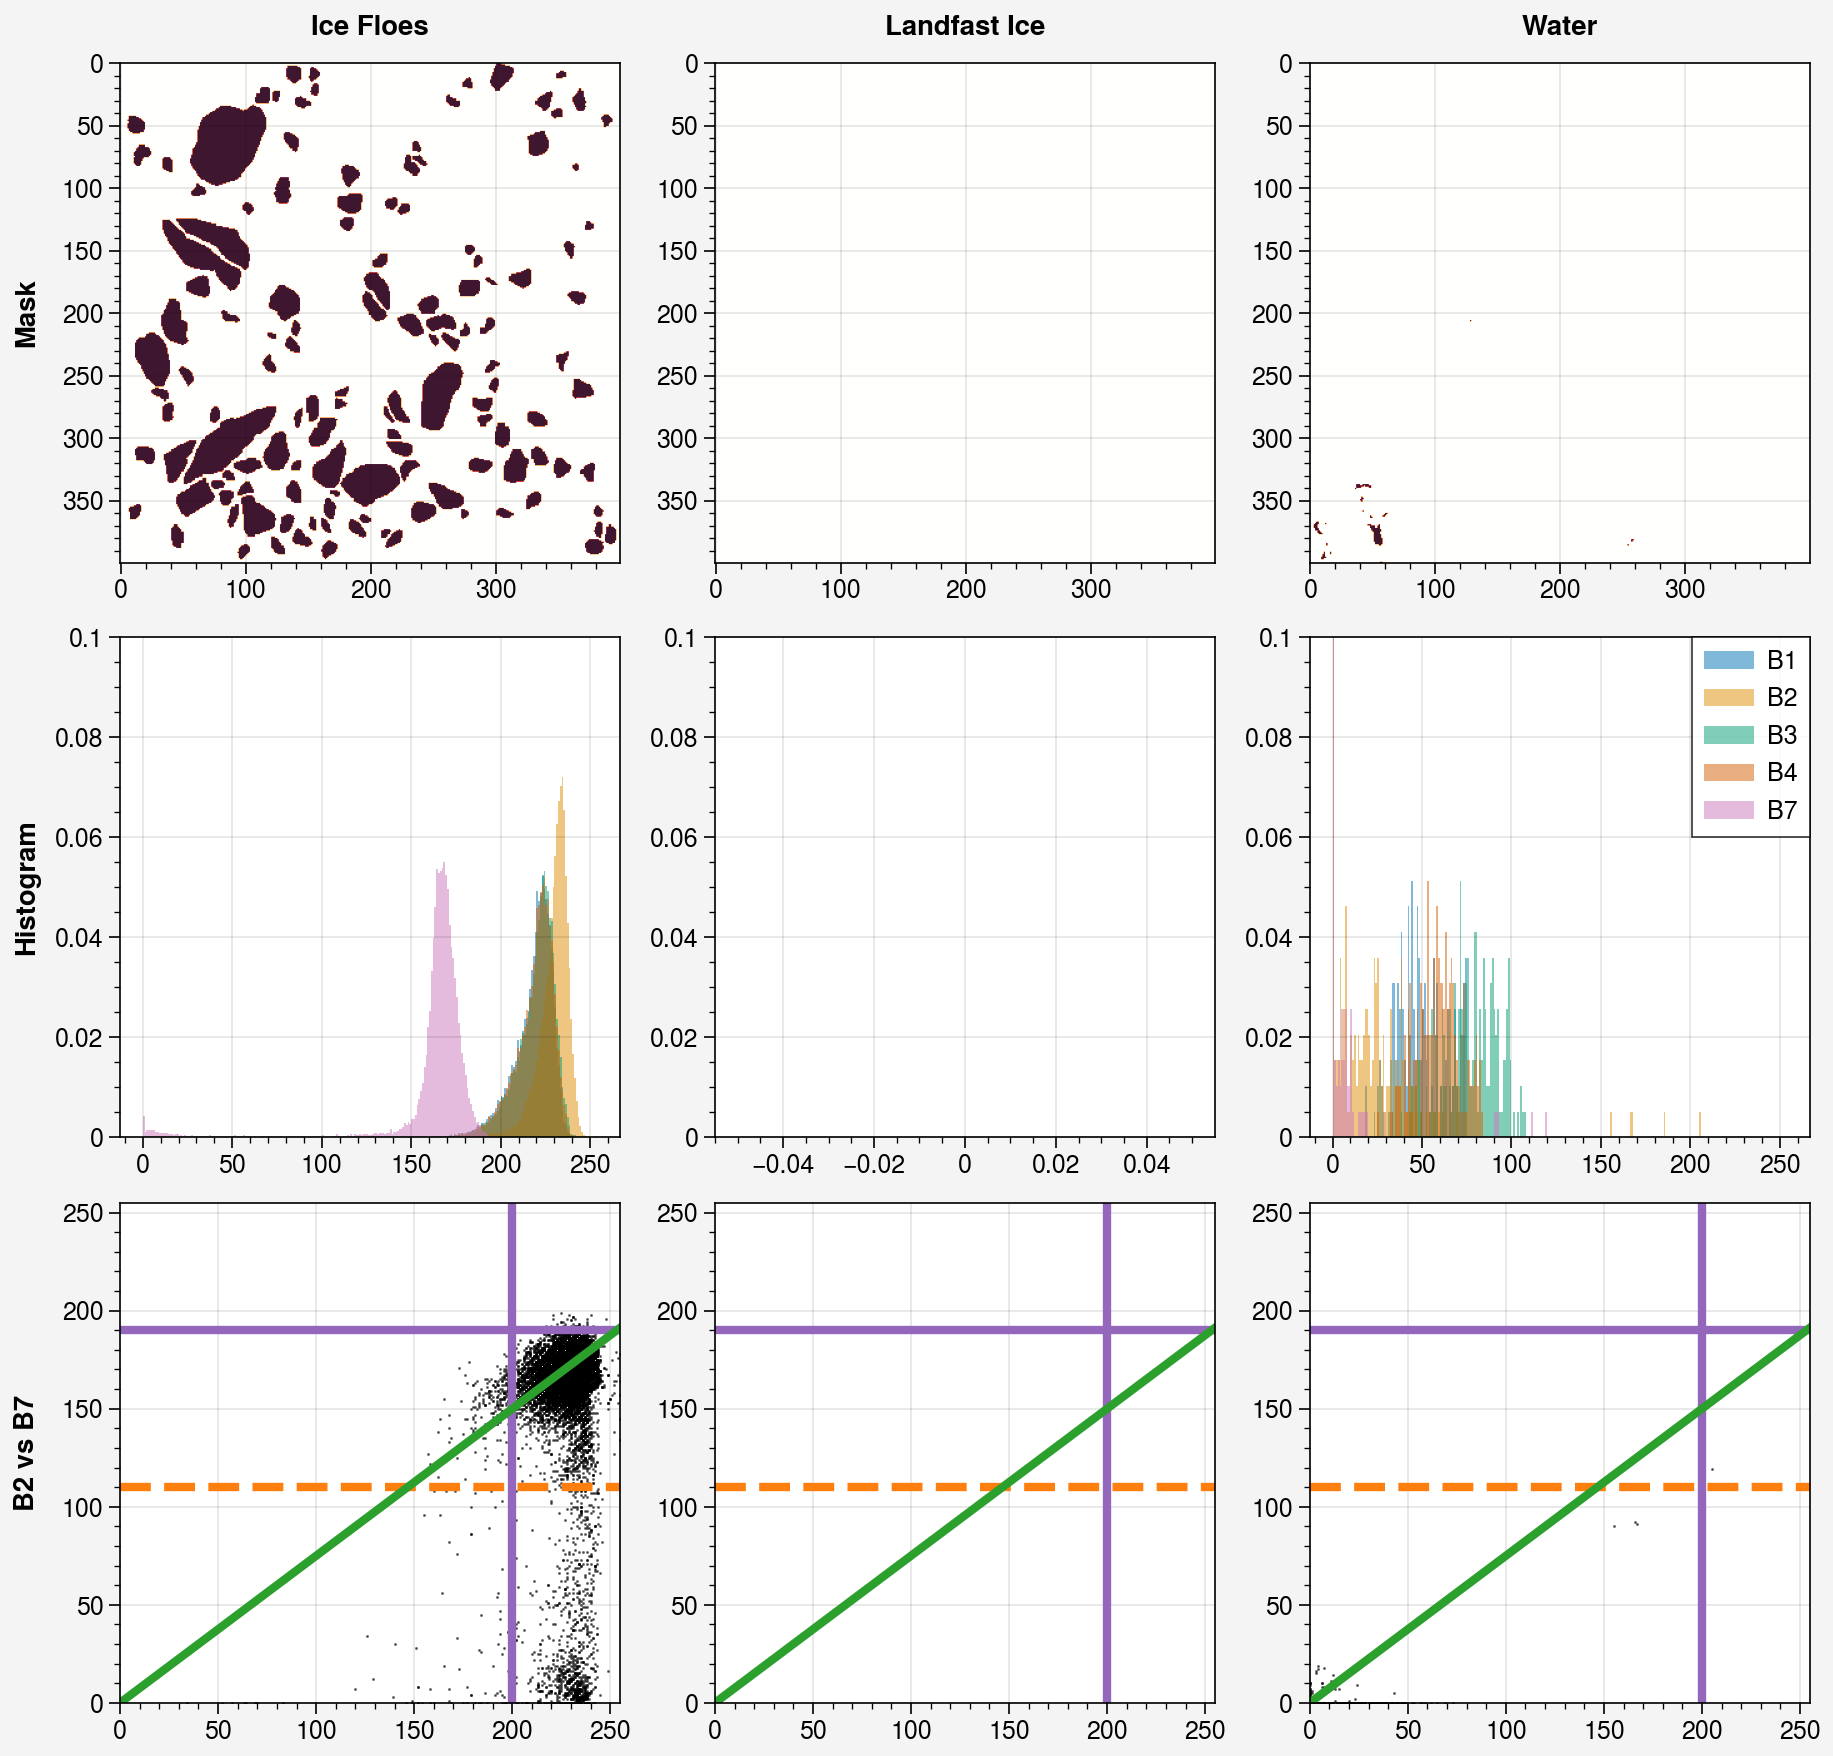

In [359]:
# Identifying ocean water 
# -- similar to the find ice labels code, there they use B7 > 5
tau_0 = 110
tau_7 = 200
tau_2 = 190
tau_R = 0.75

case = '016_terra'
TC = reshape_as_image(tc_images[case])
FC = reshape_as_image(fc_images[case])
LM_modis = np.sum(lm_images[case], axis=0) > 0
LM_masie = reshape_as_image(ml_images[case])
SI_masie = reshape_as_image(mi_images[case])

floes_manual = lb_images[case][0,:,:] > 0
lfast_manual = lf_images[case][0,:,:] > 0

B1 = TC[:,:, 0]
B4 = TC[:,:, 1]
B3 = TC[:,:, 2]
B7 = FC[:,:, 0]
B2 = FC[:,:, 1]
other = ~(lfast_manual | floes_manual | LM_modis)
other = other & (B1 < 75) # This number works for clear sky image
fig, axs = pplt.subplots(ncols=3, nrows=3, share=False)
for ax, mask in zip(axs[0,:], [floes_manual, lfast_manual, other]):
    ax.imshow(mask.astype(int))

for ax, mask in zip(axs[1,:], [floes_manual, lfast_manual, other]):
    idx = np.ravel(mask)
    for B, label in zip([B1, B2, B3, B4, B7], ['B1', 'B2', 'B3', 'B4', 'B7']):
        ax.hist(np.ravel(B)[idx], bins=np.arange(0, 255, 1), label=label, alpha=0.5, density=True, cycle='colorblind10')
    ax.format(ylim=(0, 0.1))
ax.legend(ncols=1)


for ax, mask in zip(axs[2,:], [floes_manual, lfast_manual, other]):
    idx = np.ravel(mask)
    ax.scatter(np.ravel(B2)[idx], np.ravel(B7)[idx], label=label, alpha=0.5, m='.', ms=1, color='k')
    ax.axvline(tau_7, ls='-', label='B7 < tau_7', lw=3, color='tab:purple')
    ax.axhline(tau_2, ls='-', label='B2 < tau_2', lw=3, color='tab:purple')
    ax.axhline(tau_0, ls='--', label='B7 > tau_0', lw=3, color='tab:orange')
    ax.plot([0, 255], [0, tau_R*255], color='tab:green', lw=3)
    ax.format(ylim=(0, 255), xlim=(0, 255))


axs.format(leftlabels=['Mask', 'Histogram', 'B2 vs B7'], toplabels=['Ice Floes', 'Landfast Ice', 'Water'])

TBD: 
* Assign test / train cases
* Check images with full cloud cover - any where the manual estimate especially disagrees? What threshold to use on cloud fraction for mask comparison?
* Identify cases where the cloud mask gets confused by the ice edge
* How to aggegrate? Do I fit a distribution?
* How should I report the cases where the mask should not have been removed?
* Should the B7/B2 ratio actually have a shift (e.g. (B7 + x)/(B2 + y) < ratio? Where should the line be drawn?
* All of this is really just using a piecewise linear threshold function.

# Evaluating best choices for ratios
We can use the manually labeled dataset to identify thresholds and/or breakpoints. Many images are essentially 100% opaque clouds (though to be fair some of those may include sea ice with no visible floes. We'll need to select a training and testing portion of the dataset. I think the final mask should also be cleaned up so that objects smaller than, say 100 pixels, are removed from the mask. 

1. Clouds
   1. Cloud fraction > 80%
   2. Cloud type = Opaque
   3. No visible sea ice
2. Sea ice floes, clear skies
   1. Cloud fraction < 0.2
   2. Visible floes -- verify manually
   3. Compute average of estimated cloud fraction within floe
3. Sea ice floes, cloud-obscured
   1. Visible floes
   2. Cloud type thin
   3. Compte average of estimated cloud fraction within floe
4. Open water
   1. Use the MASIE ice fraction and the landmask / 

* definitely clouds
  * opaque clouds, higher than 90% cloud cover
* definitely open water
* maybe one of those but it's unclear

Ratio B7 to B2: this is the ratio of band 7 to band 1. 
- Pixels with water tend to be dark, and have higher values of the threshold.
- Pixels with snow and ice tend to have low ratios.

NSDII2: a normalized ratio of bands 4 and 2 (band 4 = 0.55, band 2 = 0.84). Band 7 is 2.1, Band 1 is 0.65, Band 3=0.46

One description of NDSI is (R1 - R2)/(R1 + R2), where R1 is visible and R2 is shortwave infrared. So in the initial modis algorithm, they'd used band 4 for R1, and used band 6 for R2, but that band is missing in Aqua. So 

Conditions 1-2: pretty good for separating ice and water, but not perfect


`


In [162]:
df.loc[(df.cloud_fraction_manual > 0.8) & (df.visible_sea_ice=='no')]

case_number             region start_date  center_lon  center_lat  \
028_aqua          028  barents_kara_seas 2018-08-19   44.060809   82.968683   
028_terra         028  barents_kara_seas 2018-08-19   44.060809   82.968683   
036_terra         036  barents_kara_seas 2020-07-01   63.838434   79.663619   
038_aqua          038  barents_kara_seas 2014-08-02   88.339718   78.769967   
038_terra         038  barents_kara_seas 2014-08-02   88.339718   78.769967   
...               ...                ...        ...         ...         ...   
174_terra         174     sea_of_okhostk 2022-05-24  140.550500   54.183539   
177_aqua          177     sea_of_okhostk 2016-03-31  144.616592   55.785542   
177_terra         177     sea_of_okhostk 2016-03-31  144.616592   55.785542   
185_aqua          185     sea_of_okhostk 2011-05-04  154.474214   58.589917   
185_terra         185     sea_of_okhostk 2011-05-04  154.474214   58.589917   

           center_x  center_y  month  sea_ice_fraction  \
028_aqua     762500    -12500      8             0.520   
028_terra    762500    -12500      8             0.520   
036_terra   1062500    362500      7             0.960   
038_aqua     887500    837500      8             1.000   
038_terra    887500    837500      8             1.000   
...             ...       ...    ...               ...   
174_terra   -387500   3987500      5             0.762   
177_aqua    -637500   3762500      3             1.000   
177_terra   -637500   3762500      3             1.000   
185_aqua   -1162500   3287500      5             0.625   
185_terra  -1162500   3287500      5             0.625   

           mean_sea_ice_concentration  ...  cloud_fraction_manual  \
028_aqua                        0.734  ...                    1.0   
028_terra                       0.734  ...                    1.0   
036_terra                       0.848  ...                    1.0   
038_aqua                        0.752  ...                    1.0   
038_terra                       0.752  ...                    1.0   
...                               ...  ...                    ...   
174_terra                       0.522  ...                    1.0   
177_aqua                        0.725  ...                    1.0   
177_terra                       0.725  ...                    1.0   
185_aqua                        0.383  ...                    1.0   
185_terra                       0.383  ...                    1.0   

          cloud_category_manual artifacts qa_analyst qa_reviewer  fl_analyst  \
028_aqua                 opaque       yes     daniel       minki         NaN   
028_terra                opaque        no     daniel       minki         NaN   
036_terra                opaque        no     daniel       ethan        emma   
038_aqua                 opaque        no     daniel       minki         NaN   
038_terra                opaque        no     daniel       minki         NaN   
...                         ...       ...        ...         ...         ...   
174_terra                opaque       yes       emma       ellen         NaN   
177_aqua                 opaque        no       emma       ellen         NaN   
177_terra                opaque       yes       emma       ellen         NaN   
185_aqua                 opaque        no     daniel       minki         NaN   
185_terra                opaque        no     daniel       minki         NaN   

          fl_reviewer psd_file                               notes  \
028_aqua          NaN      NaN                                 NaN   
028_terra         NaN      NaN                                 NaN   
036_terra      daniel      yes  dw: redrew due to missing psd file   
038_aqua          NaN      NaN                                 NaN   
038_terra         NaN      NaN                                 NaN   
...               ...      ...                                 ...   
174_terra         NaN      NaN                                 NaN   
177_aqua      

/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/2340792646.py:7: RuntimeWarning: divide by zero encountered in divide
  nsdii2 = (b4 - b2)/(b4 + b2)
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/2340792646.py:8: RuntimeWarning: divide by zero encountered in divide
  mask_ratio = b7/b2
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/2340792646.py:8: RuntimeWarning: invalid value encountered in divide
  mask_ratio = b7/b2
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/2340792646.py:18: RuntimeWarning: divide by zero encountered in divide
  nsdi = (b2 - b7)/(b2 + b7) # alternative from VIIRS paper
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_21557/2340792646.py:18: RuntimeWarning: invalid value encountered in divide
  nsdi = (b2 - b7)/(b2 + b7) # alternative from VIIRS paper


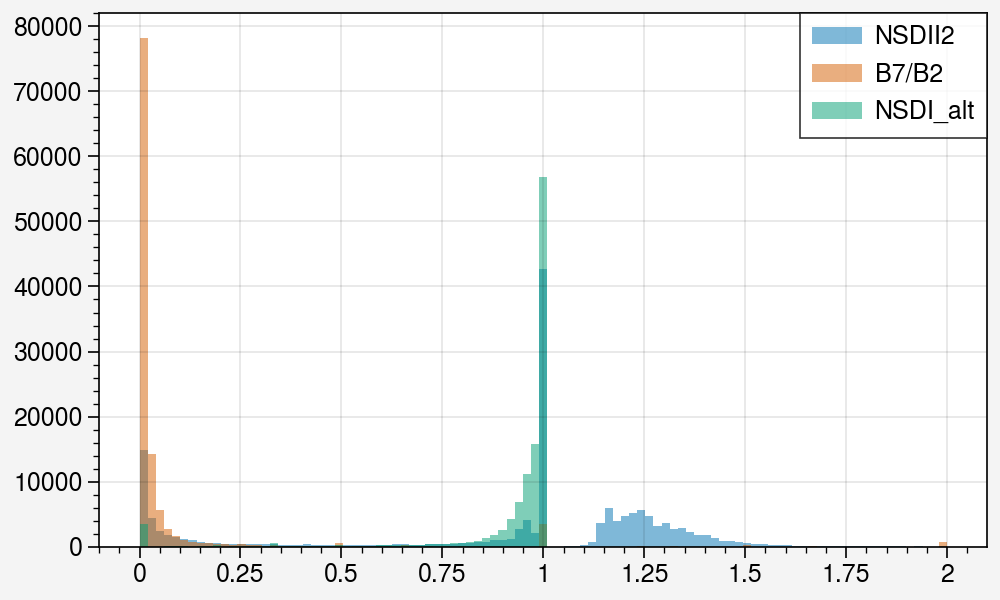

In [186]:
case = "048_aqua"
# clouds_view = fc_images[case][0,:,:] > tc # true == cloudy pixel
b4 = tc_images[case][1,:,:]
b7 = fc_images[case][0,:,:]
b2 = fc_images[case][1,:,:]

nsdii2 = (b4 - b2)/(b4 + b2)
mask_ratio = b7/b2
floes = np.ravel(lb_images[case])
nsdii2_data = np.ravel(nsdii2)
nsdii2_data = nsdii2_data[~np.isnan(nsdii2_data)]
nsdii2_data = nsdii2_data[nsdii2_data <= 2]

ratio_data = np.ravel(mask_ratio)
ratio_data = ratio_data[~np.isnan(ratio_data)]
ratio_data = ratio_data[ratio_data <= 2]

nsdi = (b2 - b7)/(b2 + b7) # alternative from VIIRS paper
nsdi_data = np.ravel(nsdi)
nsdi_data = nsdi_data[~np.isnan(nsdi_data)]
nsdi_data = nsdi_data[nsdi_data <= 2]


fig, ax = pplt.subplots(width=5, height=3)
_ = ax.hist(nsdii2_data, bins=np.linspace(0, 2, 100), alpha=0.5, label='NSDII2')
_ = ax.hist(ratio_data, bins=np.linspace(0, 2, 100), alpha=0.5, label='B7/B2')
_ = ax.hist(nsdi_data, bins=np.linspace(0, 2, 100), alpha=0.5, label='NSDI_alt')

ax.legend(ncols=1)

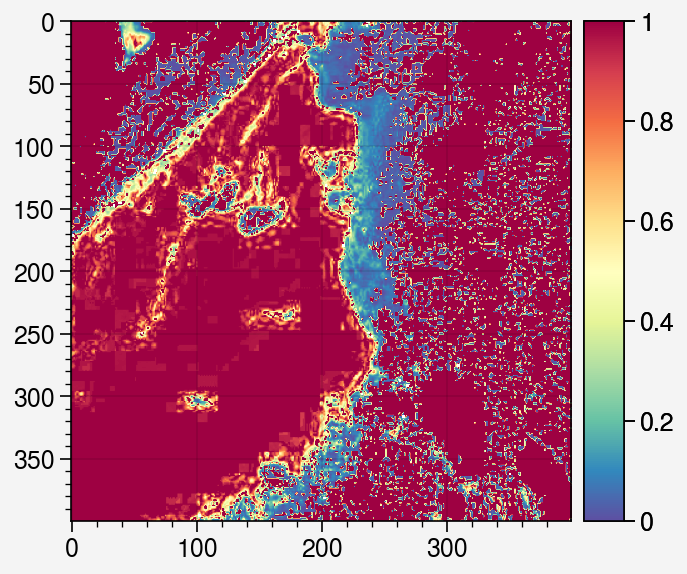

In [173]:
# 
case = "048_aqua"
# clouds_view = fc_images[case][0,:,:] > tc # true == cloudy pixel
b4 = tc_images[case][1,:,:]
b7 = fc_images[case][0,:,:]
b2 = fc_images[case][1,:,:]

nsdii2 = (b4 - b2)/(b4 + b2)
mask_ratio = b7/b2
floes = np.ravel(lb_images[case])
nsdii2_data = np.ravel(nsdii2)
nsdii2_data = nsdii2_data[~np.isnan(nsdii2_data)]
nsdii2_data = nsdii2_data[nsdii2_data <= 2]

ratio_data = np.ravel(mask_ratio)
ratio_data = ratio_data[~np.isnan(ratio_data)]
ratio_data = ratio_data[ratio_data <= 2]

fig, ax = pplt.subplots(width=5, height=3)
_ = ax.hist(nsdii2_data, bins=np.linspace(0, 2, 100), alpha=0.5, label='NSDII2')
_ = ax.hist(ratio_data, bins=np.linspace(0, 2, 100), alpha=0.5, label='B7/B2')
ax.legend(ncols=1)

/opt/homebrew/Caskroom/miniconda/base/envs/calval/lib/python3.9/site-packages/proplot/axes/cartesian.py:725: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  getattr(self, 'set_' + x + 'lim')(lim)
/opt/homebrew/Caskroom/miniconda/base/envs/calval/lib/python3.9/site-packages/proplot/axes/cartesian.py:725: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  getattr(self, 'set_' + x + 'lim')(lim)


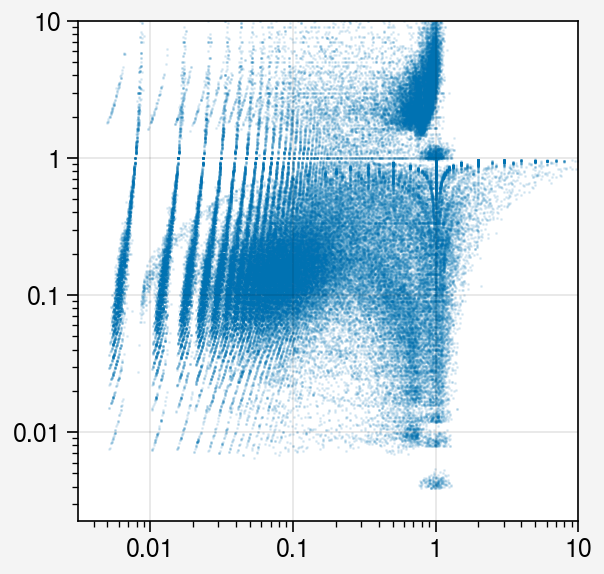

In [130]:
fig, ax = pplt.subplots()
ax.scatter(np.ravel(mask_ratio), np.ravel(nsdii2), ms=1, m='.', alpha=0.1)
ax.format(ylim=(0, 10), xlim=(0, 10), xscale='log', yscale='log')

# Alternative approach
We can look for the range of brightnesses that are observed for ice floes that are under clouds.  The thresholds should be grounded in reality in a sense at least. We can do a sweep and average across many cases, but would it be as effective? 

* We don't want a threshold so high that raising it simply increases the error in cloud cover.
* Similarly for too low.
* In between, we may want to optimize.

fc1 clear 51.0
fc1 cloudy 139.0
fc2 clear 216.0
fc2 cloudy 201.0


/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_10988/3893675673.py:52: RuntimeWarning: divide by zero encountered in divide
  brightness = np.ravel(fc_images[case][0,:,:]) / np.ravel(fc_images[case][1,:,:])
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_10988/3893675673.py:52: RuntimeWarning: invalid value encountered in divide
  brightness = np.ravel(fc_images[case][0,:,:]) / np.ravel(fc_images[case][1,:,:])


fc1/fc2 clear 0.2542372881355932
fc1/fc2 cloudy 0.672566371681416


(array([  39513.,   10583.,   15230.,   30444.,   77451.,  187605.,
         269520.,  284221.,  277805.,  284934.,  281314.,  283564.,
         297697.,  383640.,  510575.,  508250.,  493175.,  533687.,
         579795.,  620945.,  726828.,  948219., 1266400.,  962458.,
         747087.,  399469.,  161241.,   78826.,   49729.]),
 array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
        0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
        0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
        0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
        0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
        0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ]),
 <BarContainer object of 29 artists>)

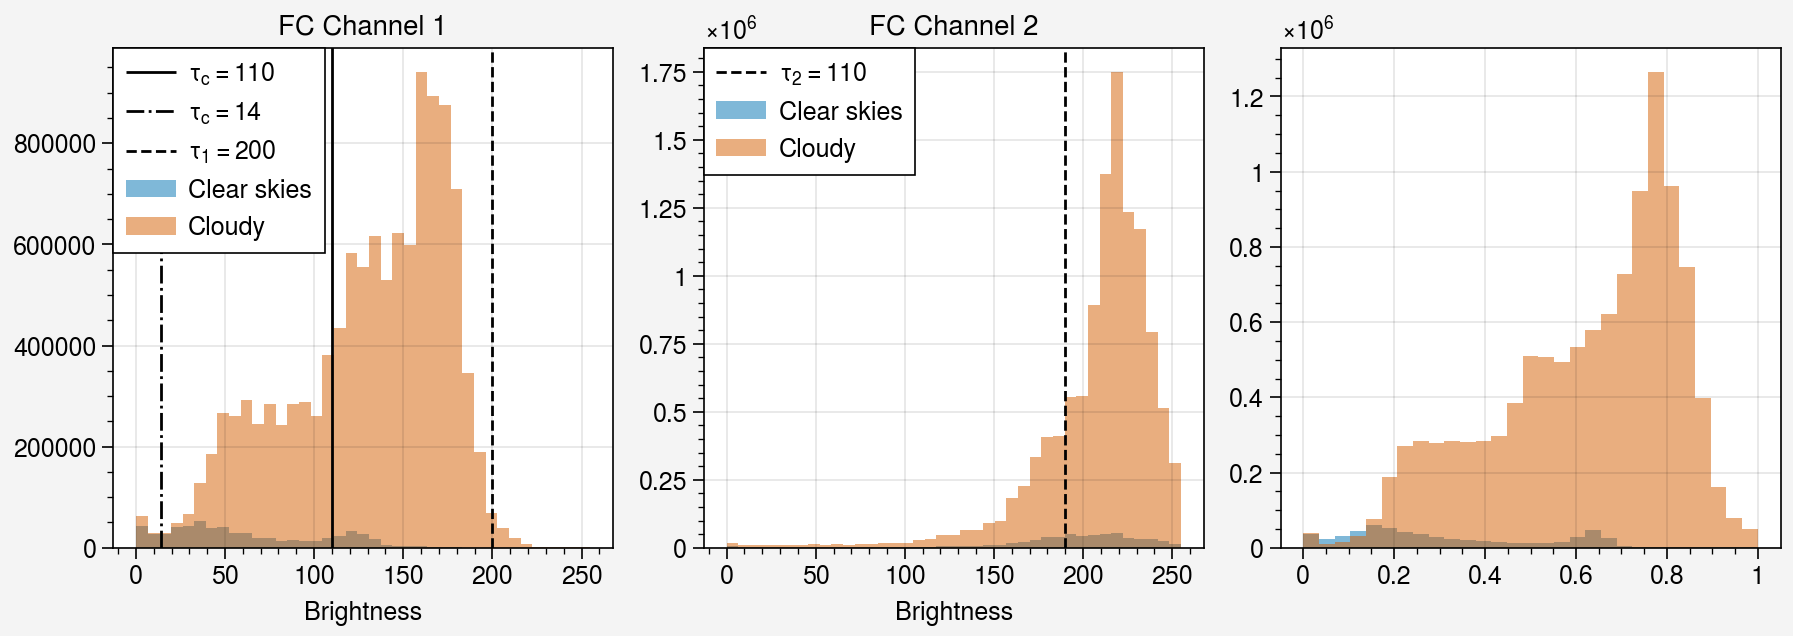

In [105]:
nearly_full_cloud_cover = df.loc[df.visible_sea_ice=='no'].index
fig, ax = pplt.subplots(ncols=3, sharex=False, sharey=False)
all_cloudy = []
all_clear = []
for case in nearly_full_cloud_cover:
    if case in cf_images:
        if fc_images[case].shape[1] == 400:
            brightness = np.ravel(fc_images[case][0,:,:])
            cloudy = np.ravel(cf_images[case]) > 80
            clear = np.ravel(cf_images[case]) <= 80
            all_cloudy.append(brightness[cloudy])
            all_clear.append(brightness[clear])
all_clear = np.hstack(all_clear)
all_cloudy = np.hstack(all_cloudy)
print('fc1', 'clear', np.median(all_clear))
print('fc1', 'cloudy', np.median(all_cloudy))
ax[0].hist(all_clear, alpha=0.5, label='Clear skies', bins=np.linspace(0, 255, 40))
ax[0].hist(all_cloudy, alpha=0.5, label='Cloudy', bins=np.linspace(0, 255, 40))
ax[0].axvline(110, label='$\\tau_c = 110$', color='k', ls='-', lw=1)
ax[0].axvline(14, label='$\\tau_c = 14$', color='k', ls='-.', lw=1)
ax[0].axvline(200, label='$\\tau_1 = 200$', color='k', ls='--', lw=1)
ax[0].format(title='FC Channel 1', xlabel='Brightness')
ax[0].legend(ncols=1, alpha=1)

all_cloudy = []
all_clear = []
for case in nearly_full_cloud_cover:
    if case in cf_images:
        if fc_images[case].shape[1] == 400:
            brightness = np.ravel(fc_images[case][1,:,:])
            cloudy = np.ravel(cf_images[case]) > 80
            clear = np.ravel(cf_images[case]) <= 80
            all_cloudy.append(brightness[cloudy])
            all_clear.append(brightness[clear])
all_cloudy = np.hstack(all_cloudy)
all_clear = np.hstack(all_clear)
print('fc2', 'clear', np.median(all_cloudy))
print('fc2', 'cloudy', np.median(all_clear))

ax[1].hist(all_clear, alpha=0.5, label='Clear skies', bins=np.linspace(0, 255, 40))
ax[1].hist(all_cloudy, alpha=0.5, label='Cloudy', bins=np.linspace(0, 255, 40))
ax[1].axvline(190, label='$\\tau_2 = 110$', color='k', ls='--', lw=1)
ax[1].format(title='FC Channel 2', xlabel='Brightness')
ax[1].legend(ncols=1, alpha=1)

all_cloudy = []
all_clear = []
for case in nearly_full_cloud_cover:
    if case in cf_images:
        if fc_images[case].shape[1] == 400:
            brightness = np.ravel(fc_images[case][0,:,:]) / np.ravel(fc_images[case][1,:,:])
            cloudy = np.ravel(cf_images[case]) > 80
            clear = np.ravel(cf_images[case]) <= 80
            all_cloudy.append(brightness[cloudy])
            all_clear.append(brightness[clear])

r = np.hstack(all_clear)
r = r[(r >= 0) & (r <= 1)]
print('fc1/fc2', 'clear', np.median(r))
ax[2].hist(r, alpha=0.5, label='Clear skies', bins=np.linspace(0, 1, 30))

r = np.hstack(all_cloudy)
r = r[(r >= 0) & (r <= 1)]
print('fc1/fc2', 'cloudy', np.median(r))
ax[2].hist(r, alpha=0.5, label='Clear skies', bins=np.linspace(0, 1, 30))


In [ ]:
fig, ax = pplt.subplots(ncols=3, sharex=False, sharey=False)
sea_ice_cloudy = []
sea_ice_clear = []
for case in lb_images:
    if lb_images[case].shape[1] == 400:
        brightness = np.ravel(fc_images[case][0,:,:])
        cloudy = np.ravel(cf_images[case]) > 80
        sea_ice = np.ravel(lb_images[case][0,:,:]) > 0
        sea_ice_cloudy.append(brightness[cloudy & sea_ice])
        sea_ice_clear.append(brightness[~cloudy & sea_ice])
sea_ice_clear = np.hstack(sea_ice_clear)
sea_ice_cloudy = np.hstack(sea_ice_cloudy)
print('fc1', 'clear', np.median(sea_ice_clear))
print('fc1', 'cloudy', np.median(sea_ice_cloudy))
ax[0].hist(np.hstack(sea_ice_clear), alpha=0.5, label='Clear skies', bins=np.linspace(0, 255, 40))
ax[0].hist(np.hstack(sea_ice_cloudy), alpha=0.5, label='Cloudy', bins=np.linspace(0, 255, 40))
ax[0].axvline(110, label='$\\tau_c = 110$', color='k', ls='-', lw=1)
ax[0].axvline(14, label='$\\tau_c = 14$', color='k', ls='-.', lw=1)
ax[0].axvline(200, label='$\\tau_1 = 200$', color='k', ls='--', lw=1)
ax[0].format(title='FC Channel 1', xlabel='Brightness')
ax[0].legend(ncols=1, alpha=1)

sea_ice_cloudy = []
sea_ice_clear = []
for case in lb_images:
    if lb_images[case].shape[1] == 400:
        brightness = np.ravel(fc_images[case][1,:,:])
        cloudy = np.ravel(cf_images[case]) > 80
        sea_ice = np.ravel(lb_images[case][0,:,:]) > 0
        sea_ice_cloudy.append(brightness[cloudy & sea_ice])
        sea_ice_clear.append(brightness[~cloudy & sea_ice])
sea_ice_clear = np.hstack(sea_ice_clear)
sea_ice_cloudy = np.hstack(sea_ice_cloudy)
print('fc2', 'clear', np.median(sea_ice_clear))
print('fc2', 'cloudy', np.median(sea_ice_cloudy))

ax[1].hist(np.hstack(sea_ice_clear), alpha=0.5, label='Clear skies', bins=np.linspace(0, 255, 40))
ax[1].hist(np.hstack(sea_ice_cloudy), alpha=0.5, label='Cloudy', bins=np.linspace(0, 255, 40))
ax[1].axvline(190, label='$\\tau_2 = 110$', color='k', ls='--', lw=1)
ax[1].format(title='FC Channel 2', xlabel='Brightness')
ax[1].legend(ncols=1, alpha=1)

sea_ice_cloudy = []
sea_ice_clear = []
for case in lb_images:
    if lb_images[case].shape[1] == 400:
        brightness = np.ravel(fc_images[case][0,:,:]) / np.ravel(fc_images[case][1,:,:])
        cloudy = np.ravel(cf_images[case]) > 80
        sea_ice = np.ravel(lb_images[case][0,:,:]) > 0
        sea_ice_cloudy.append(brightness[cloudy & sea_ice])
        sea_ice_clear.append(brightness[~cloudy & sea_ice])

r = np.hstack(sea_ice_clear)
r = r[(r >= 0) & (r <= 1)]
print('fc1/fc2', 'clear', np.median(r))
ax[2].hist(r, alpha=0.5, label='Clear skies', bins=np.linspace(0, 1, 30))

r = np.hstack(sea_ice_cloudy)
r = r[(r >= 0) & (r <= 1)]
print('fc1/fc2', 'cloudy', np.median(r))

ax[2].hist(r, alpha=0.5, label='Cloudy', bins=np.linspace(0, 1, 30))
ax[2].axvline(0.75, label='$\\tau_r = 0.75$', color='k', ls='-', lw=1)
ax[2].format(title='FC Channel 1-2 Ratio', xlabel='Brightness', xlim=(0, 1))
ax[2].legend(ncols=1, alpha=1)
fig.save('../figures/false_color_histograms.png', dpi=300)


We divided the ground truth sea ice floe data into cloudy and clear pixels based on a threshold of 80% cloud cover. What we can see is that the original $\tau_c = 100$ ensured no clear-sky sea ice floes were covered by the first step of the cloud mask algorithm. With the stricter setting of $\tau_c = 14$, a larger fraction of the ice would be initially considered cloud-covered.

$\tau_1$ sets an upper bound for the brightness of sea ice under clouds in channel 1, while the threshold $\tau_2$ on channel 2 functions is a lower bound for how bright Channel 2 needs to be to count as ice. Finally, the brightness ratio is considered. We see that ice under clear skies has a markedly different ratio: under clear skies, most ice has low ratios (under 0.2), while under clouds, the ratios can be up to 0.85.

We test the following ranges:
* $\tau_1$ from 50 to 200
* $\tau_2$ from 100 to 250
* $\tau_r$ from 0 to 0.9




# Applying the min-max operation to a larger set of images

Thinking of the right approach here. It might be better to use a histogram method for the choices of T1 and T2, then to optimize over the possible values of R. The weighting is going to be important and I'm sure there's a variety of ways that the difference in floe numbers across images could be an issue.


In [106]:
labeled_cases = []
for case in lb_images:
    if lb_images[case].shape[1] == 400:
        labeled_cases.append(case)
        
df_training = df.loc[labeled_cases].sample(frac=2/3, replace=False, random_state=306)
df_testing = df.loc[labeled_cases].loc[[x for x in labeled_cases if x not in df_training.index]]

In [113]:
%%time
tc = 14

r_upper = 0.75 # 0 = Only using t1 and t2
example_results = []
for case in df_training.index:
    if (case in fc_images) & (case in lb_images):
        for t1 in range(50, 205, 5):
            for t2 in range(100, 255, 5):
                clouds_view, cloud_mask = generate_masks(fc_images[case], t1=t1, t2=t2, r_lower=0, r_upper=r_upper, tc=tc)
                manual_floe_labels = lb_images[case][0,:,:]
            
                delta_cf = cloud_fraction_loss_function(cloud_mask, clouds_view)
                delta_si = sea_ice_fraction_loss_function(cloud_mask, manual_floe_labels)
                mean_error = (clouds_view & (manual_floe_labels == 0)) != cloud_mask
                example_results.append([case, tc, t1, t2, r_upper, delta_cf, delta_si, np.mean(mean_error), np.mean(clouds_view)])
example_results = pd.DataFrame(example_results, columns=['case', 'tc', 't_1', 't_2', 'ratio', 'delta_cf', 'delta_si', 'mean_error', 'cloud_fraction'])

/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_10988/1523296688.py:6: RuntimeWarning: invalid value encountered in divide
  mask_ratio = fc_image[0,:,:]/fc_image[1,:,:]
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_10988/1523296688.py:6: RuntimeWarning: divide by zero encountered in divide
  mask_ratio = fc_image[0,:,:]/fc_image[1,:,:]


CPU times: user 41.6 s, sys: 80.4 ms, total: 41.6 s
Wall time: 41.6 s


In [114]:
example_results['t1t2'] = [str(x) + '_' + str(y) for x, y in zip(example_results.t_1, example_results.t_2)]


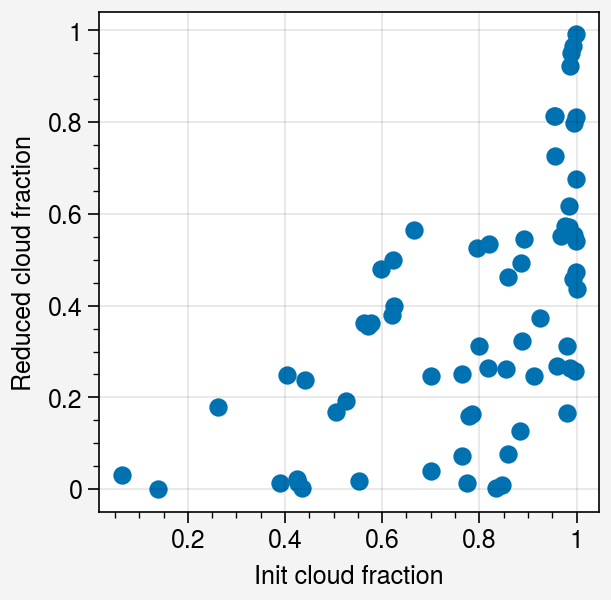

In [115]:
fig, ax = pplt.subplots()
test = example_results.loc[example_results.t1t2 == '200_190']
ax.scatter(test.cloud_fraction, test.cloud_fraction*test.delta_cf) 
ax.format(xlabel='Init cloud fraction', ylabel='Reduced cloud fraction')

In [ ]:
sea_ice_fraction_loss_function??

In [116]:
r_upper = 0.25 # 0 = Only using t1 and t2
example_results = []
for case in df_training.index:
    for t1 in range(50, 205, 5):
        for t2 in range(100, 255, 5):
            clouds_view, cloud_mask = generate_masks(fc_images[case], t1=t1, t2=t2, r_lower=0, r_upper=r_upper, tc=tc)
            manual_floe_labels = lb_images[case][0,:,:]
        
            delta_cf = cloud_fraction_loss_function(cloud_mask, clouds_view)
            delta_si = sea_ice_fraction_loss_function(cloud_mask, manual_floe_labels)
            mean_error = (clouds_view & (manual_floe_labels == 0)) != cloud_mask
            example_results.append([case, tc, t1, t2, r_upper, delta_cf, delta_si, np.mean(mean_error)])
example_results_r25 = pd.DataFrame(example_results, columns=['case', 'tc', 't_1', 't_2', 'ratio', 'delta_cf', 'delta_si', 'mean_error'])

/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_10988/1523296688.py:6: RuntimeWarning: invalid value encountered in divide
  mask_ratio = fc_image[0,:,:]/fc_image[1,:,:]
/var/folders/dc/61xkz8s134xgs5c2fmqrjgrr0000gn/T/ipykernel_10988/1523296688.py:6: RuntimeWarning: divide by zero encountered in divide
  mask_ratio = fc_image[0,:,:]/fc_image[1,:,:]


KeyError: '100_aqua'

In [ ]:
example_results_r25['t1t2'] = [str(x) + '_' + str(y) for x, y in zip(example_results_r25.t_1, example_results_r25.t_2)]

In [ ]:
fig, axs = pplt.subplots(height=5, ncols=3, nrows=2, share=False)
data = example_results[['t_1', 't_2', 'delta_cf', 'delta_si', 'mean_error', 't1t2']].groupby('t1t2').mean()
# data = data.where(data.delta_cf <= 0.2)
for ax, var in zip(axs[0,:], ['delta_si', 'delta_cf', 'mean_error']):
    c=ax.contourf(data.pivot_table(index='t_2', columns='t_1', values=var), cmap='tokyo_r', vmin=0, vmax=1)
    ax.colorbar(c, label=var)
    ax.format(ylabel='$\\tau_2$')
    ax.format(xlabel='$\\tau_1$')

data = example_results_r25[['t_1', 't_2', 'delta_cf', 'delta_si', 'mean_error', 't1t2']].groupby('t1t2').mean()

for ax, var in zip(axs[1,:], ['delta_si', 'delta_cf', 'mean_error']):
    c=ax.contourf(data.pivot_table(index='t_2', columns='t_1', values=var), cmap='tokyo_r', vmin=0, vmax=1)
    ax.colorbar(c, label=var)
    ax.format(ylabel='$\\tau_2$')
    ax.format(xlabel='$\\tau_1$')

axs.format(leftlabels=['r=0.75', 'r=0.25'], toplabels=['Fraction sea ice uncovered', 'Reduction in cloud cover', 'Mean difference'])

Metrics for the "thin cloud identification" step. 
1. Quantify the reduction in cloud cover (what we want to minimize). Pixels where there were clouds, the clouds were removed, and no ice floe is visible. $CF_{all}$ and $CF_{thin}$ and not $SI$.
2. Quantify the increase in sea ice floe visibility. Pixels where there were clouds, the clouds were removed, and an ice floe is visible. $CF_{all}$ and $CF_{thin}$ and $SI$.

Interpretation: the pixels with ratio less than a give amount are removed from the cloud mask as likely containing sea ice. So with a high ratio, only the T1 and T2 thresholds are limiting anything. Lower ratios result in larger numbers of cloud pixels being masked.

These are not adjusted for the number of sea ice pixels.